## 1. Carga de librerias, modelos y herramientas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utilsforecast.preprocessing import fill_gaps
from sklearn.preprocessing import MinMaxScaler
from pickle import dump

In [2]:
def pretreat_data_df(df, col_name):
    new_df = df[df['interaction'] == col_name].copy()
    new_df.rename(columns={'data.value': col_name}, inplace=True)
    new_df.drop(columns='interaction', inplace=True)
    new_df.set_index('timestamp', inplace=True)
    new_df[col_name] = new_df[col_name].astype(float)
    return new_df

def pretreat_true_false_data_df(df, col_name):
    new_df = df[df['interaction'] == col_name].copy()
    new_df.rename(columns={'data.value': col_name}, inplace=True)
    new_df.drop(columns='interaction', inplace=True)
    new_df.set_index('timestamp', inplace=True)
    new_df[col_name] = new_df[col_name].apply(lambda x: 1 if x == 'true' else 0)
    return new_df

In [3]:
# Load the data
data = pd.read_csv('../data/wot-data-db.interactions-datas_sewy214.csv')
data['timestamp'] = pd.to_datetime(data['timestamp']).dt.round("min").dt.tz_localize(None)
df_test = data[['timestamp', 'data.value', 'interaction']]

df_temperature = pretreat_data_df(df_test, 'temperature')
df_brightness = pretreat_data_df(df_test, 'brightness')
df_humidity = pretreat_data_df(df_test, 'humidity')
df_airpressure = pretreat_data_df(df_test, 'airpressure')
df_co2 = pretreat_data_df(df_test, 'CO2')

len(df_temperature), len(df_brightness), len(df_humidity), len(df_airpressure), len(df_co2)

(40321, 36026, 89930, 74426, 167201)

In [4]:
df_temperature.head()

,temperature
timestamp,
2023-03-03 09:31:00,19.0
2023-03-03 09:32:00,18.9
2023-03-03 09:34:00,19.0
2023-03-03 09:36:00,19.1
2023-03-03 09:37:00,19.3


In [5]:
df_airpressure.head()

,airpressure
timestamp,
2023-03-03 09:31:00,104350.0
2023-03-03 09:33:00,104360.0
2023-03-03 09:37:00,104350.0
2023-03-03 09:49:00,104340.0
2023-03-03 09:50:00,104330.0


In [6]:
df_brightness.head()

,brightness
timestamp,
2023-03-03 09:31:00,320.00
2023-03-03 09:37:00,326.08
2023-03-03 09:47:00,330.88
2023-03-03 09:48:00,320.00
2023-03-03 09:49:00,330.88


In [7]:
df_co2.head()

,CO2
timestamp,
2023-03-03 09:31:00,748.16
2023-03-03 09:32:00,773.76
2023-03-03 09:33:00,780.80
2023-03-03 09:34:00,792.32
2023-03-03 09:35:00,798.72


In [8]:
df_humidity.head()

,humidity
timestamp,
2023-03-03 09:31:00,23.8
2023-03-03 09:32:00,24.0
2023-03-03 09:33:00,24.3
2023-03-03 09:34:00,24.4
2023-03-03 09:35:00,24.5


In [9]:
def plot_data(df, col_name):
    plt.figure(figsize=(10,6))
    plt.plot(df)
    plt.title('Sewy 214 ' + col_name)
    plt.ylabel(col_name)
    plt.show()

def plot_hist(df, col_name):
    plt.figure(figsize=(10,6))
    plt.hist(df)
    plt.title('Sewy 214 ' + col_name)
    plt.ylabel('Frequency')
    plt.show()

def plot_day_data(df, col_name):
    plt.figure(figsize=(10,6))
    plt.plot(df[col_name].loc['2023-03-05':'2023-03-06'])
    plt.title('1 day Sewy 214 ' + col_name)
    plt.ylabel(col_name)
    plt.show()

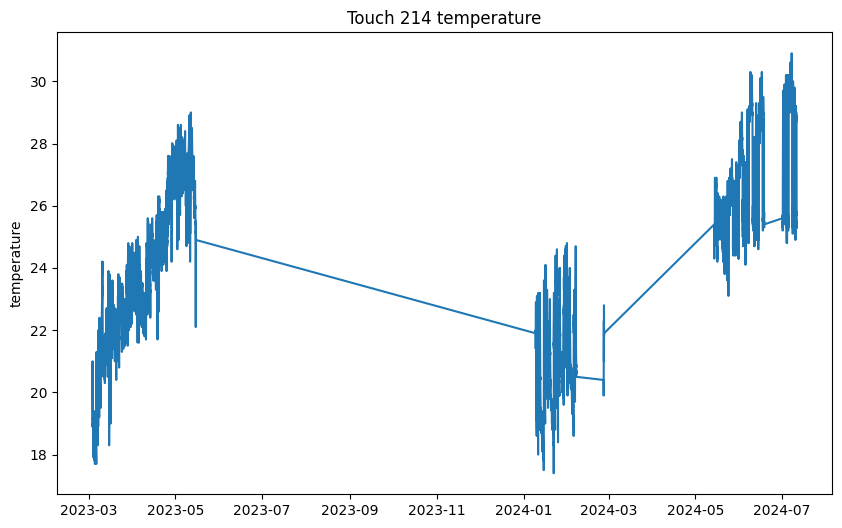

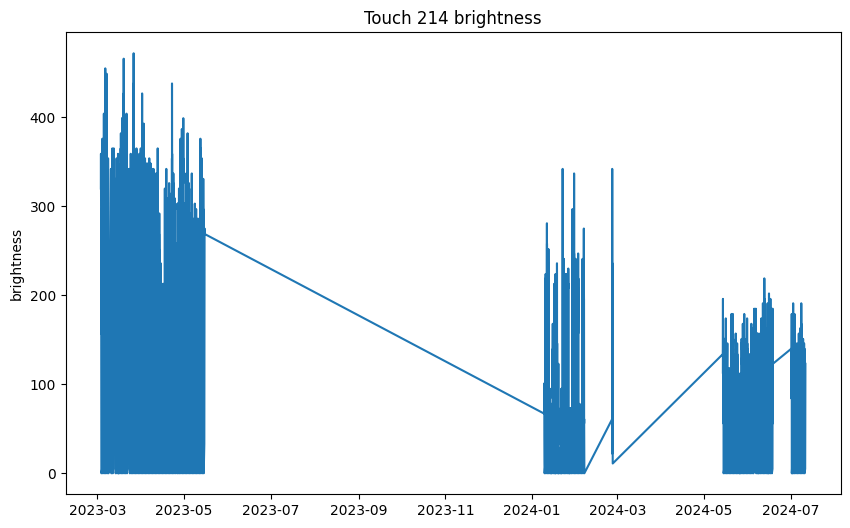

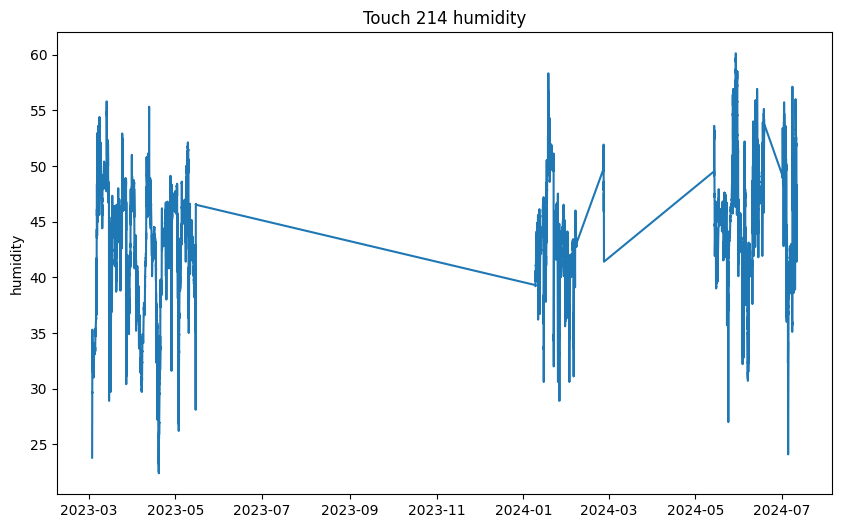

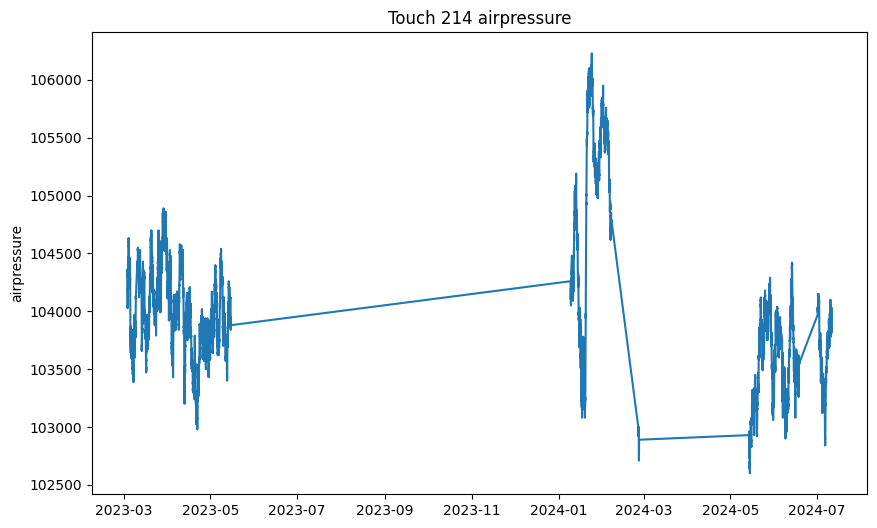

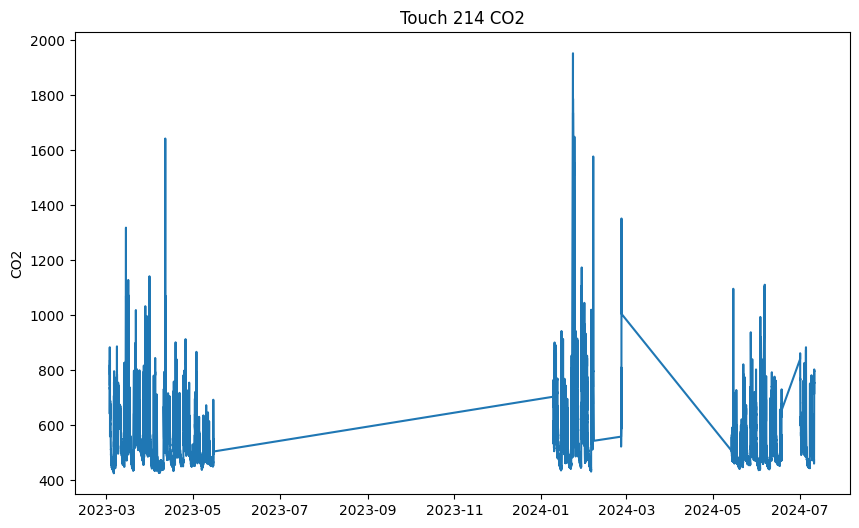

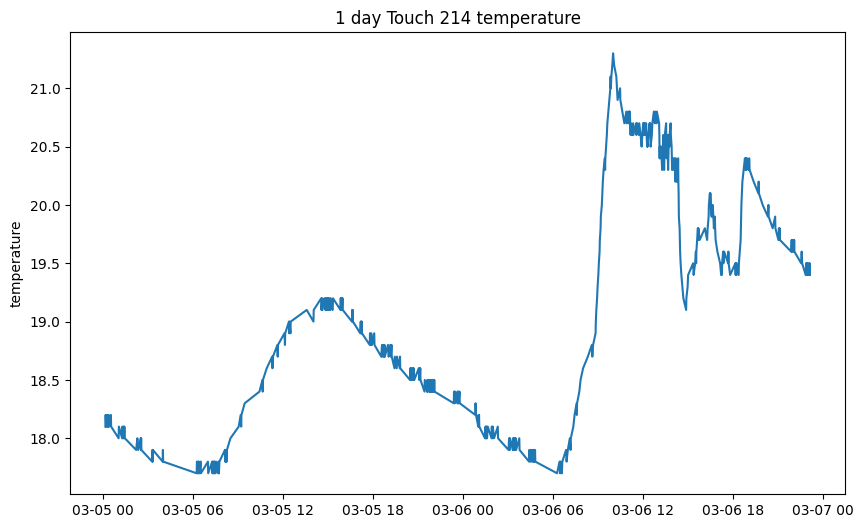

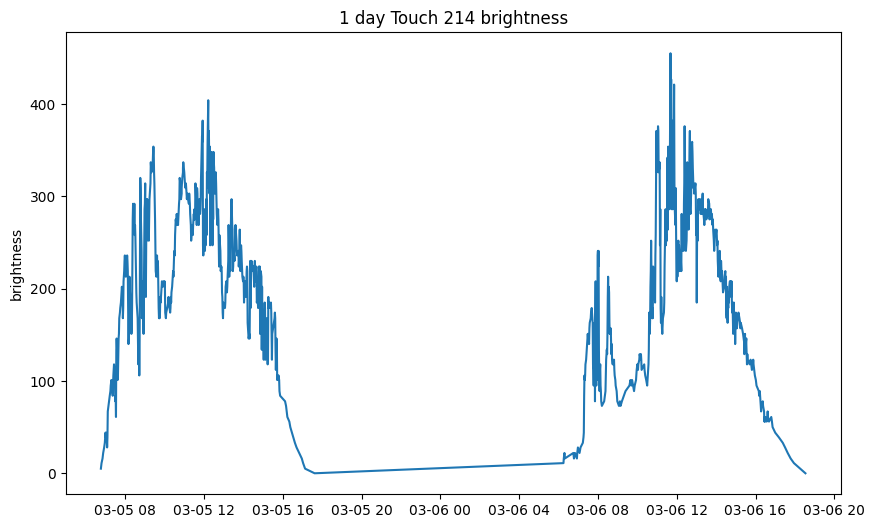

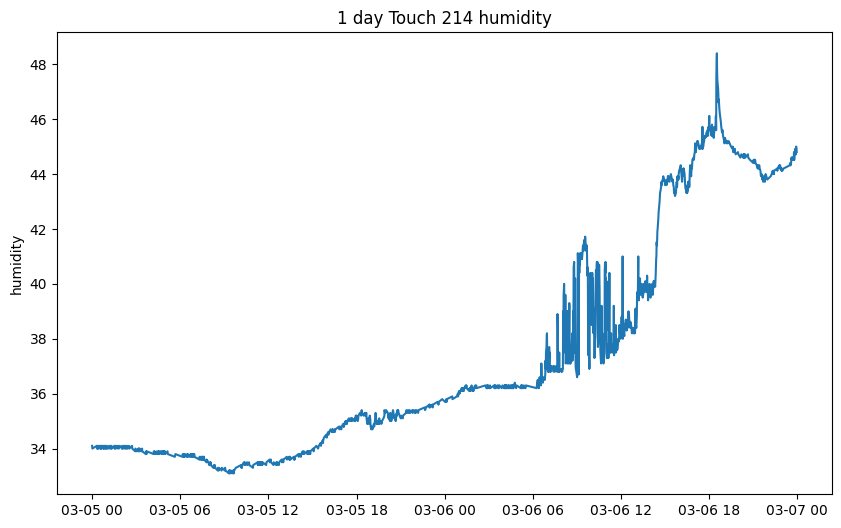

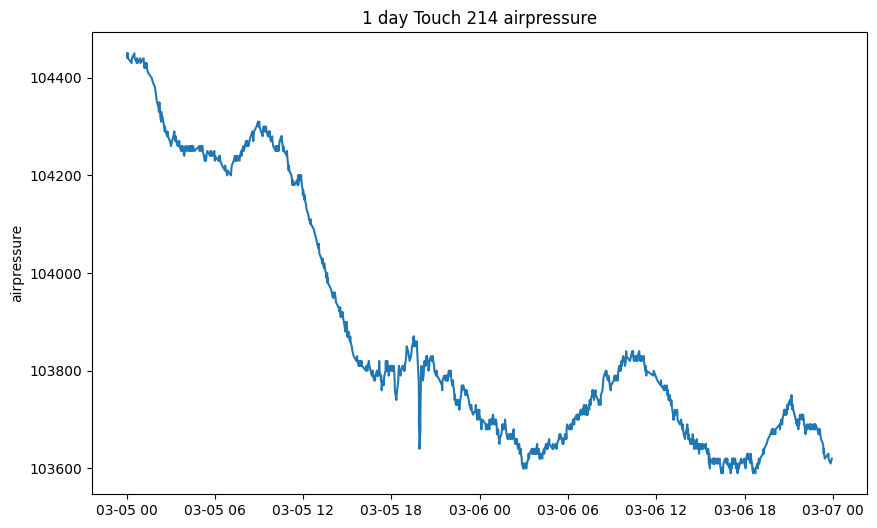

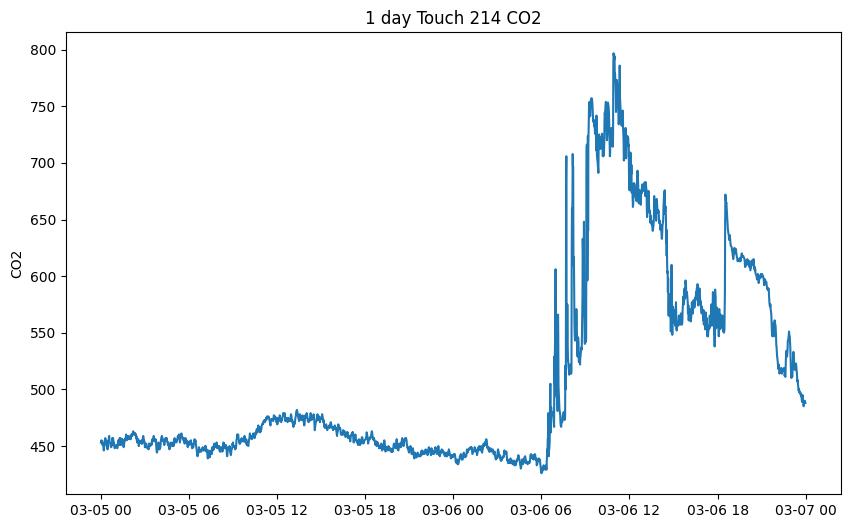

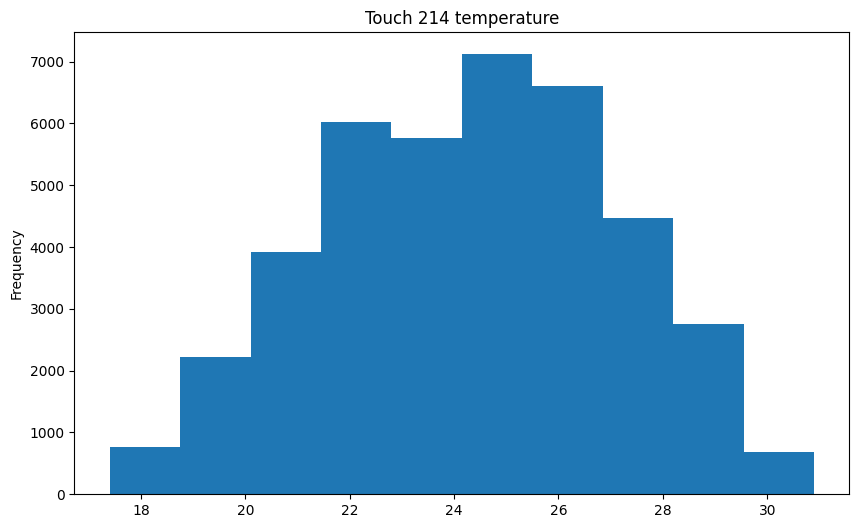

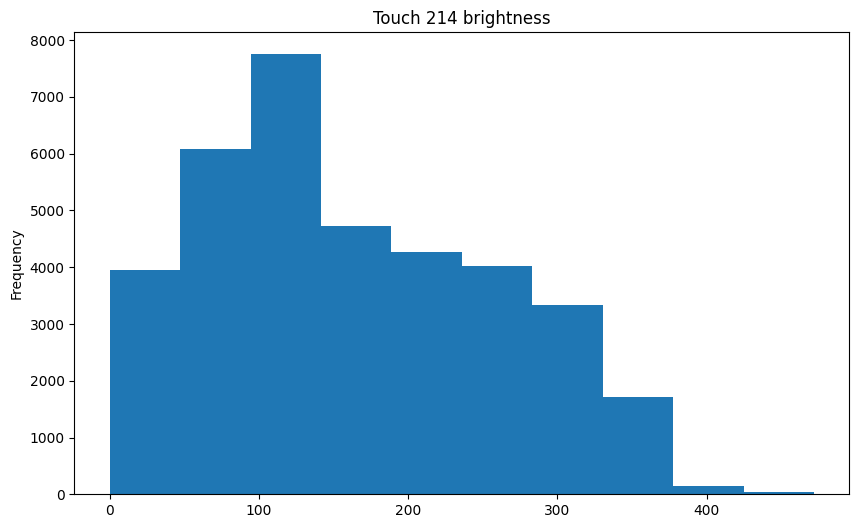

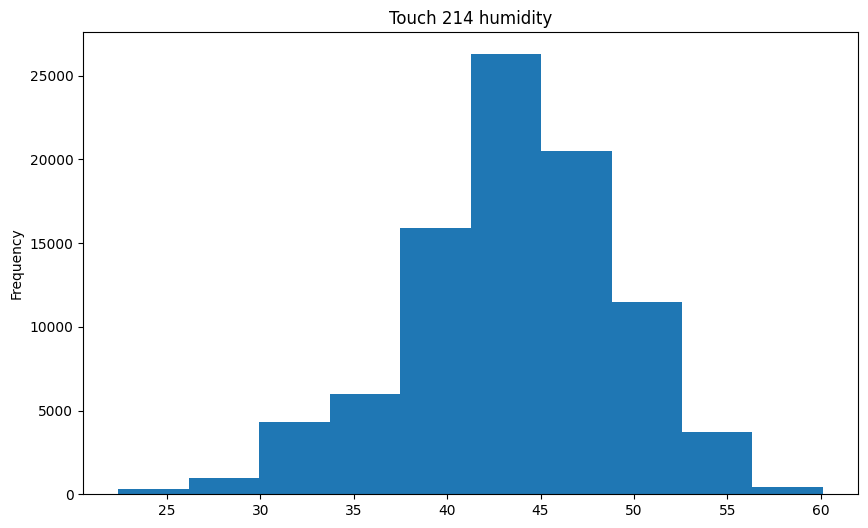

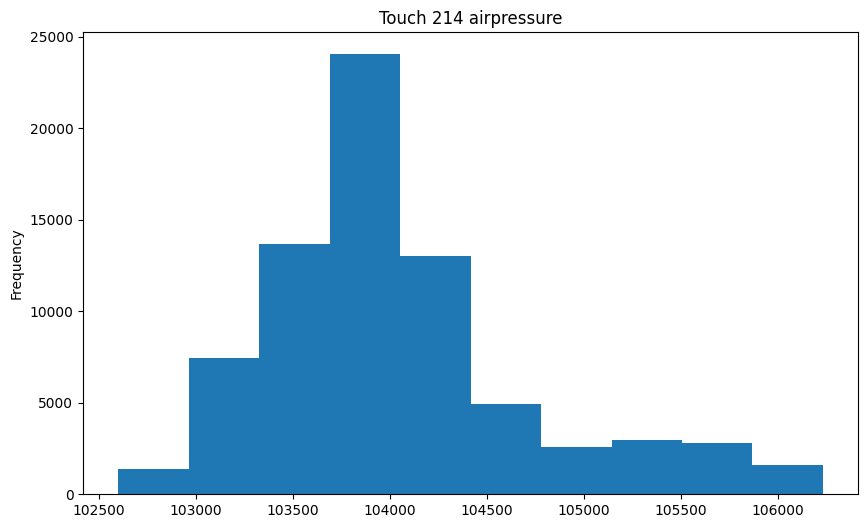

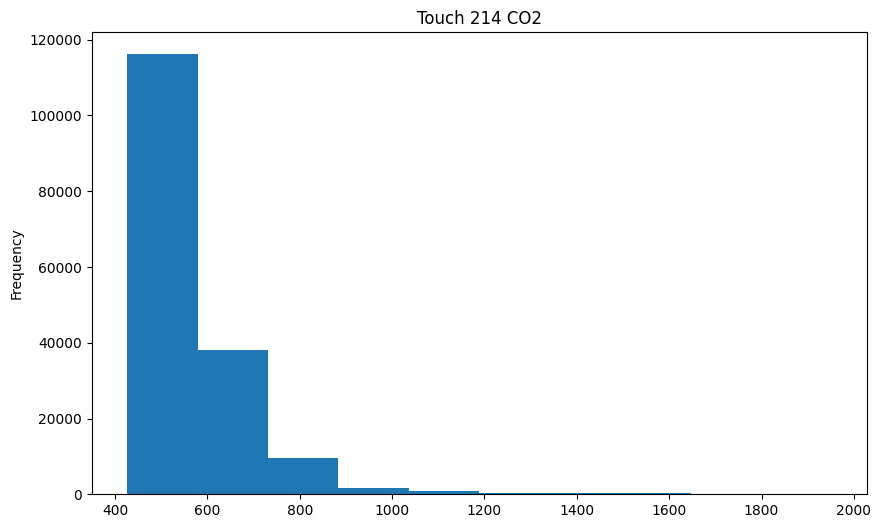

In [10]:
plot_data(df_temperature, 'temperature')
plot_data(df_brightness, 'brightness')
plot_data(df_humidity, 'humidity')
plot_data(df_airpressure, 'airpressure')
plot_data(df_co2, 'CO2')
plot_day_data(df_temperature, 'temperature')
plot_day_data(df_brightness, 'brightness')
plot_day_data(df_humidity, 'humidity')
plot_day_data(df_airpressure, 'airpressure')
plot_day_data(df_co2, 'CO2')
plot_hist(df_temperature, 'temperature')
plot_hist(df_brightness, 'brightness')
plot_hist(df_humidity, 'humidity')
plot_hist(df_airpressure, 'airpressure')
plot_hist(df_co2, 'CO2')

Debido a todos estos problemas, se ha optado por tomar únicamente el tramo entre marzo y mayo de 2023.

In [11]:
def reduce_df(df, start_date, end_date):
    return df[(df.index >= start_date) & (df.index <= end_date)]

In [12]:
reduced_df_temperature = reduce_df(df_temperature, '2023-03-01', '2023-05-15')
reduced_df_brightness = reduce_df(df_brightness, '2023-03-01', '2023-05-15')
reduced_df_humidity = reduce_df(df_humidity, '2023-03-01', '2023-05-15')
reduced_df_airpressure = reduce_df(df_airpressure, '2023-03-01', '2023-05-15')
reduced_df_co2 = reduce_df(df_co2, '2023-03-01', '2023-05-15')

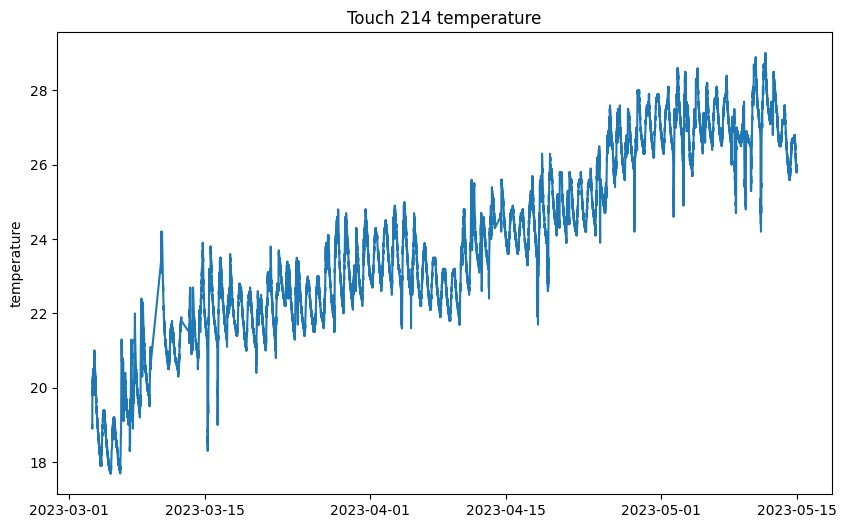

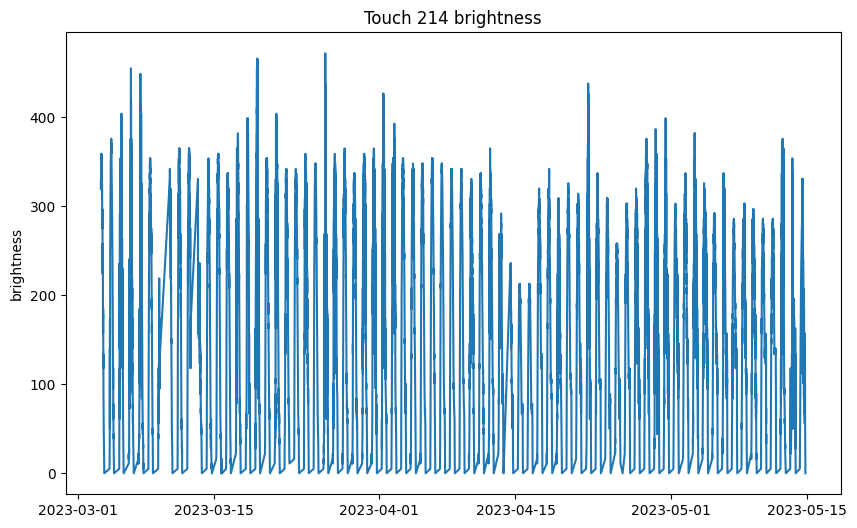

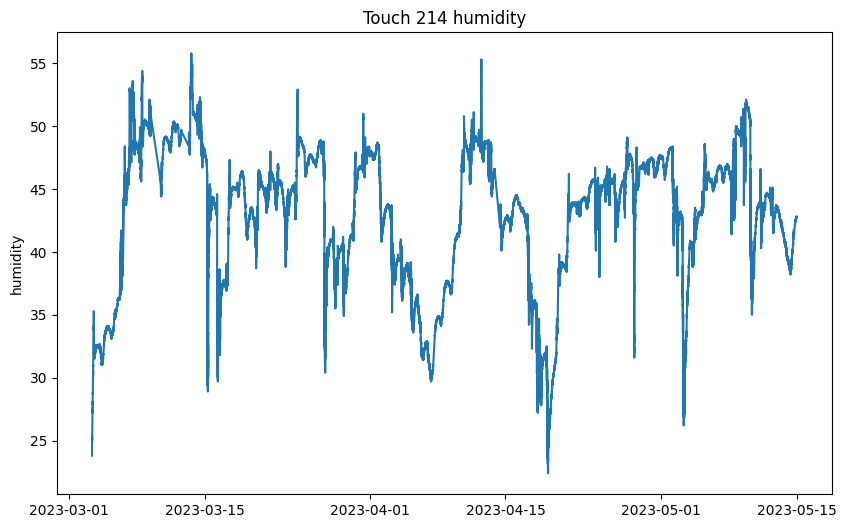

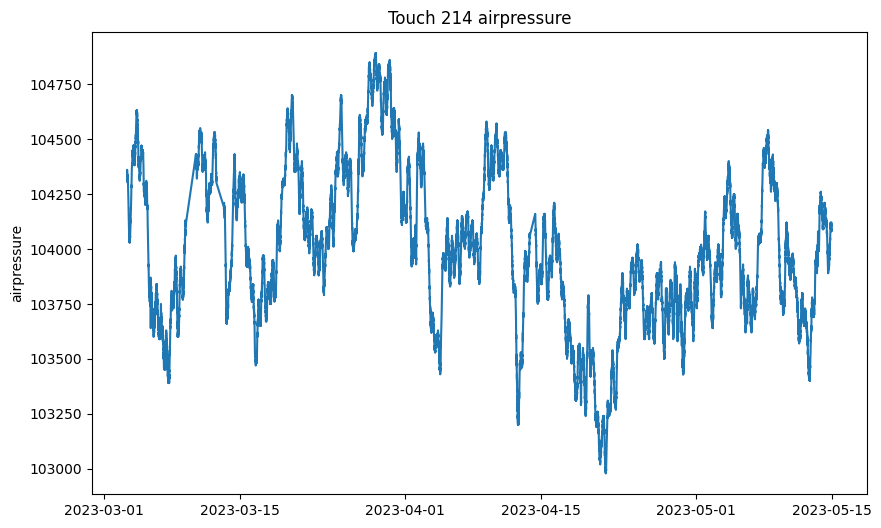

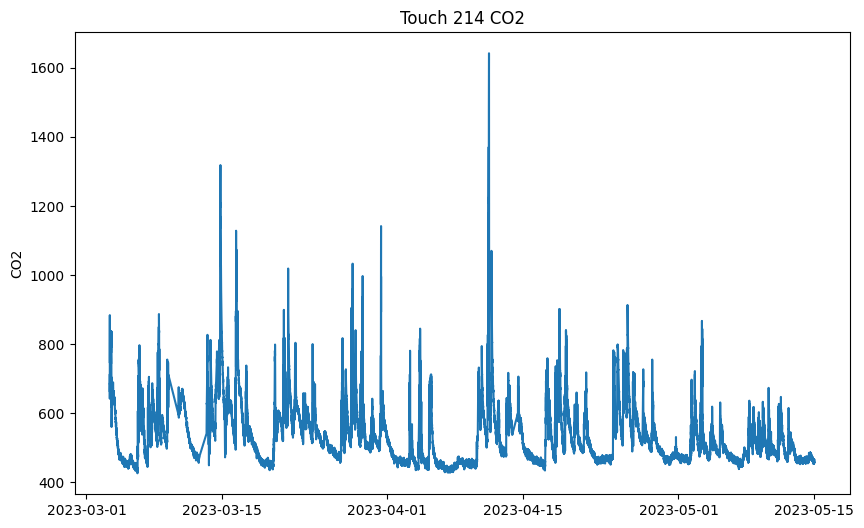

In [13]:
plot_data(reduced_df_temperature, 'temperature')
plot_data(reduced_df_brightness, 'brightness')
plot_data(reduced_df_humidity, 'humidity')
plot_data(reduced_df_airpressure, 'airpressure')
plot_data(reduced_df_co2, 'CO2')

Registros duplicados

In [14]:
def delete_duplicates(df, col_name):
    print(col_name + ' - Número de registros duplicados:', df.index.duplicated().sum())
    if df.index.duplicated().sum() > 0:
        df = df.groupby(df.index).mean()
        print(col_name + ' - Número de registros tras eliminar duplicados:' + str(len(df)))
    else:
        print('No hay registros duplicados')
    return df
    

In [15]:
reduced_df_temperature = delete_duplicates(reduced_df_temperature, 'temperature')
reduced_df_brightness = delete_duplicates(reduced_df_brightness, 'brightness')
reduced_df_humidity = delete_duplicates(reduced_df_humidity, 'humidity')
reduced_df_airpressure = delete_duplicates(reduced_df_airpressure, 'airpressure')
reduced_df_co2 = delete_duplicates(reduced_df_co2, 'CO2')

temperature - Número de registros duplicados: 66
temperature - Número de registros tras eliminar duplicados:19612
brightness - Número de registros duplicados: 137
brightness - Número de registros tras eliminar duplicados:21869
humidity - Número de registros duplicados: 236
humidity - Número de registros tras eliminar duplicados:42250
airpressure - Número de registros duplicados: 155
airpressure - Número de registros tras eliminar duplicados:35850
CO2 - Número de registros duplicados: 624
CO2 - Número de registros tras eliminar duplicados:80434


In [16]:
def fill_gaps_df(df,col_name, boolean=False):
    print(col_name + " - Original data: ", len(df), "rows")
    
    # Rellenamos los valores faltantes
    df = df.resample('min').asfreq()
    if boolean:
        df[col_name] = df[col_name].interpolate(method='ffill')
    else:
        df[col_name] = df[col_name].interpolate(method='linear', limit_direction='both')
    
    print(col_name + " - Updated data: ", len(df), "rows")
    
    return df

In [17]:
reduced_df_temperature = fill_gaps_df(reduced_df_temperature, 'temperature')
reduced_df_brightness = fill_gaps_df(reduced_df_brightness, 'brightness')
reduced_df_humidity = fill_gaps_df(reduced_df_humidity, 'humidity')
reduced_df_airpressure = fill_gaps_df(reduced_df_airpressure, 'airpressure')
reduced_df_co2 = fill_gaps_df(reduced_df_co2, 'CO2')

temperature - Original data:  19612 rows
temperature - Updated data:  104524 rows
brightness - Original data:  21869 rows
brightness - Updated data:  104254 rows
humidity - Original data:  42250 rows
humidity - Updated data:  104548 rows
airpressure - Original data:  35850 rows
airpressure - Updated data:  104549 rows
CO2 - Original data:  80434 rows
CO2 - Updated data:  104550 rows


In [18]:
reduced_df_temperature

,temperature
timestamp,
2023-03-03 09:31:00,19.000000
2023-03-03 09:32:00,18.900000
2023-03-03 09:33:00,18.950000
2023-03-03 09:34:00,19.000000
2023-03-03 09:35:00,19.050000
...,...
2023-05-14 23:30:00,25.866667
2023-05-14 23:31:00,25.883333
2023-05-14 23:32:00,25.900000


In [19]:
reduced_df_airpressure

,airpressure
timestamp,
2023-03-03 09:31:00,104350.000000
2023-03-03 09:32:00,104355.000000
2023-03-03 09:33:00,104360.000000
2023-03-03 09:34:00,104357.500000
2023-03-03 09:35:00,104355.000000
...,...
2023-05-14 23:55:00,104087.647059
2023-05-14 23:56:00,104088.235294
2023-05-14 23:57:00,104088.823529


In [20]:
reduced_df_brightness

,brightness
timestamp,
2023-03-03 09:31:00,320.000000
2023-03-03 09:32:00,321.013333
2023-03-03 09:33:00,322.026667
2023-03-03 09:34:00,323.040000
2023-03-03 09:35:00,324.053333
...,...
2023-05-14 19:00:00,2.500000
2023-05-14 19:01:00,1.875000
2023-05-14 19:02:00,1.250000


In [21]:
reduced_df_co2

,CO2
timestamp,
2023-03-03 09:31:00,748.16
2023-03-03 09:32:00,773.76
2023-03-03 09:33:00,780.80
2023-03-03 09:34:00,792.32
2023-03-03 09:35:00,798.72
...,...
2023-05-14 23:56:00,455.04
2023-05-14 23:57:00,455.28
2023-05-14 23:58:00,455.52


In [22]:
reduced_df_airpressure

,airpressure
timestamp,
2023-03-03 09:31:00,104350.000000
2023-03-03 09:32:00,104355.000000
2023-03-03 09:33:00,104360.000000
2023-03-03 09:34:00,104357.500000
2023-03-03 09:35:00,104355.000000
...,...
2023-05-14 23:55:00,104087.647059
2023-05-14 23:56:00,104088.235294
2023-05-14 23:57:00,104088.823529


Definimos datos de inicio y fin ignorando primer y último dia

In [23]:
reduced_df_temperature = reduced_df_temperature[(reduced_df_temperature.index >= '2023-03-06') & (reduced_df_temperature.index <= '2023-05-14')]
reduced_df_brightness = reduced_df_brightness[(reduced_df_brightness.index >= '2023-03-06') & (reduced_df_brightness.index <= '2023-05-14')]
reduced_df_humidity = reduced_df_humidity[(reduced_df_humidity.index >= '2023-03-06') & (reduced_df_humidity.index <= '2023-05-14')]
reduced_df_airpressure = reduced_df_airpressure[(reduced_df_airpressure.index >= '2023-03-06') & (reduced_df_airpressure.index <= '2023-05-14')]
reduced_df_co2 = reduced_df_co2[(reduced_df_co2.index >= '2023-03-06') & (reduced_df_co2.index <= '2023-05-14')]
len(reduced_df_temperature), len(reduced_df_brightness), len(reduced_df_humidity), len(reduced_df_airpressure), len(reduced_df_co2)

(99361, 99361, 99361, 99361, 99361)

Normalizamos los datos

In [24]:
def normalize_df(df):
    scaler = MinMaxScaler()
    df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
    return df_normalized, scaler

In [25]:
reduced_df_temperature, scaler_temperature = normalize_df(reduced_df_temperature)
reduced_df_brightness, scaler_brightness = normalize_df(reduced_df_brightness)
reduced_df_humidity, scaler_humidity = normalize_df(reduced_df_humidity)
reduced_df_airpressure, scaler_airpressure = normalize_df(reduced_df_airpressure)
reduced_df_co2, scaler_co2 = normalize_df(reduced_df_co2)

Por último, combinamos todos los datos en una misma tabla

In [26]:
# Merge all df into one
completed_df = pd.concat([reduced_df_temperature, reduced_df_brightness, reduced_df_humidity, reduced_df_airpressure, reduced_df_co2], axis=1)
completed_df

,temperature,brightness,humidity,airpressure,CO2
timestamp,,,,,
2023-03-06 00:00:00,0.051242,0.011776,0.398703,0.380890,0.012049
2023-03-06 00:01:00,0.051099,0.011806,0.398453,0.379581,0.012207
2023-03-06 00:02:00,0.050956,0.011837,0.398204,0.378272,0.012365
2023-03-06 00:03:00,0.050814,0.011868,0.398802,0.376963,0.013944
2023-03-06 00:04:00,0.050671,0.011899,0.399401,0.374346,0.013154
...,...,...,...,...,...
2023-05-13 23:56:00,0.751622,0.005097,0.514970,0.630017,0.032097
2023-05-13 23:57:00,0.751327,0.005115,0.517964,0.628272,0.032886
2023-05-13 23:58:00,0.751032,0.005132,0.514970,0.627836,0.033675


## Normalización de los valores + añadir periodicidad

In [27]:
day = 60*60*24
year = 365.2425*day

completed_df['seconds'] = completed_df.index.map(pd.Timestamp.timestamp)

# A partir del seno y coseno podemos trabajar también la periodicidad de los datos. Concretamente, la de los dias y el año.

completed_df['day_sin'] = np.sin(completed_df['seconds'] * (2 * np.pi / day))
completed_df['day_cos'] = np.cos(completed_df['seconds'] * (2 * np.pi / day))
completed_df['year_sin'] = np.sin(completed_df['seconds'] * (2 * np.pi / year))
completed_df['year_cos'] = np.cos(completed_df['seconds'] * (2 * np.pi / year))

completed_df.drop(columns=['seconds'], inplace=True)

completed_df

,temperature,brightness,humidity,airpressure,CO2,day_sin,day_cos,year_sin,year_cos
timestamp,,,,,,,,,
2023-03-06 00:00:00,0.051242,0.011776,0.398703,0.380890,0.012049,-1.267246e-11,1.000000,0.892796,0.450461
2023-03-06 00:01:00,0.051099,0.011806,0.398453,0.379581,0.012207,4.363309e-03,0.999990,0.892802,0.450450
2023-03-06 00:02:00,0.050956,0.011837,0.398204,0.378272,0.012365,8.726535e-03,0.999962,0.892807,0.450439
2023-03-06 00:03:00,0.050814,0.011868,0.398802,0.376963,0.013944,1.308960e-02,0.999914,0.892812,0.450429
2023-03-06 00:04:00,0.050671,0.011899,0.399401,0.374346,0.013154,1.745241e-02,0.999848,0.892818,0.450418
...,...,...,...,...,...,...,...,...,...
2023-05-13 23:56:00,0.751622,0.005097,0.514970,0.630017,0.032097,-1.745241e-02,0.999848,0.752028,-0.659131
2023-05-13 23:57:00,0.751327,0.005115,0.517964,0.628272,0.032886,-1.308960e-02,0.999914,0.752020,-0.659140
2023-05-13 23:58:00,0.751032,0.005132,0.514970,0.627836,0.033675,-8.726536e-03,0.999962,0.752012,-0.659149


## 5. Creación y estudio de predicciones con LSMT.

Las redes Long Shot Memory Term son las redes neuronales indicadas para llevar a cabo la predicción de valores futuros dentro de series temporales. Dentro de este cuaderno analizaremos los resultados a partir de una implementación manual y con el uso de métodos ya definidos por Tensorflow/PyTorch 

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, InputLayer, TimeDistributed, RepeatVector
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError, RootMeanSquaredError
from tensorflow.keras.losses import MeanSquaredError as mse_tf, MeanAbsoluteError as mae_tf

Antes de comenzar a definir el modelo será necesario detallar el número de datos necesarios para la entrada y la salida. En este caso, se ha optado por predecir hasta 15 minutos en el futuro a partir de los datos de los 60 minutos anteriores. Esta funcionalidad se cumple con el método split_sequences(). Las entradas (input) se localizarán en X, mientras que y será el resultado que dan. 

In [29]:
def split_sequence(df, window_size = 60, target_size = 15):
    X, y = [], []
    for i in range(len(df)-window_size-target_size):
        X.append(df.iloc[i:(i+window_size)].values)
        row = df.iloc[(i+window_size):(i+window_size+target_size)].values
        y.append(row[:, :-4].flatten())
    return np.array(X), np.array(y)

In [30]:
WINDOW_SIZE = 60
TARGET_SIZE = 15
X, y = split_sequence(completed_df, WINDOW_SIZE, TARGET_SIZE)
X.shape, y.shape

((99286, 60, 9), (99286, 75))

In [31]:
X

array([[[ 0.05124179,  0.01177552,  0.39870259, ...,  1.        ,
          0.89279631,  0.4504606 ],
        [ 0.05109906,  0.01180627,  0.39845309, ...,  0.99999048,
          0.89280169,  0.45044994],
        [ 0.05095632,  0.01183702,  0.39820359, ...,  0.99996192,
          0.89280707,  0.45043927],
        ...,
        [ 0.03933137,  0.01352802,  0.40818363, ...,  0.96923091,
          0.89310284,  0.44985256],
        [ 0.03834808,  0.01355876,  0.40918164, ...,  0.96814764,
          0.89310821,  0.44984189],
        [ 0.0373648 ,  0.01358951,  0.41017964, ...,  0.96704594,
          0.89311358,  0.44983122]],

       [[ 0.05109906,  0.01180627,  0.39845309, ...,  0.99999048,
          0.89280169,  0.45044994],
        [ 0.05095632,  0.01183702,  0.39820359, ...,  0.99996192,
          0.89280707,  0.45043927],
        [ 0.05081359,  0.01186776,  0.3988024 , ...,  0.99991433,
          0.89281245,  0.45042861],
        ...,
        [ 0.03834808,  0.01355876,  0.40918164, ...,  

In [32]:
y

array([[0.03638151, 0.01362025, 0.40868263, ..., 0.41167665, 0.36474695,
        0.01894238],
       [0.03539823, 0.013651  , 0.40718563, ..., 0.41317365, 0.36649215,
        0.01854775],
       [0.04424779, 0.01368175, 0.40818363, ..., 0.41017964, 0.36125654,
        0.01815312],
       ...,
       [0.75752212, 0.00487184, 0.52245509, ..., 0.51796407, 0.62827225,
        0.03288608],
       [0.75575221, 0.00488918, 0.5239521 , ..., 0.51497006, 0.62783595,
        0.03367535],
       [0.7539823 , 0.00490652, 0.52095808, ..., 0.51596806, 0.62739965,
        0.03630624]])

In [33]:
lsmt_separation_rows = int(len(X)*0.8)
X_train, X_test = X[:lsmt_separation_rows], X[lsmt_separation_rows:]
y_train, y_test = y[:lsmt_separation_rows], y[lsmt_separation_rows:]

len(X_train), len(X_test), len(y_train), len(y_test)

(79428, 19858, 79428, 19858)

In [34]:
HandMadeLSTM = Sequential()
HandMadeLSTM.add(InputLayer((WINDOW_SIZE, len(completed_df.columns))))
HandMadeLSTM.add(LSTM(64, activation='relu'))
HandMadeLSTM.add(Dense(TARGET_SIZE*(len(completed_df.columns)-4)))

HandMadeLSTM.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75)             │         4,875 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,819 (93.04 KB)

 Trainable params: 23,819 (93.04 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
modelPath = '../LSMTTensorflow/bestModelSewy214.keras'
checkpoints = ModelCheckpoint(modelPath, save_best_only=True)
HandMadeLSTM.compile(optimizer=Adam(learning_rate=0.001), loss=mse_tf(), metrics=[mae_tf(), RootMeanSquaredError()])

In [36]:
HandMadeLSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[checkpoints])

Epoch 1/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - loss: 0.0169 - mean_absolute_error: 0.0599 - root_mean_squared_error: 0.1110 - val_loss: 6.8787e-04 - val_mean_absolute_error: 0.0163 - val_root_mean_squared_error: 0.0262
Epoch 2/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 4.3558e-04 - mean_absolute_error: 0.0108 - root_mean_squared_error: 0.0209 - val_loss: 5.9951e-04 - val_mean_absolute_error: 0.0145 - val_root_mean_squared_error: 0.0245
Epoch 3/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 4.0704e-04 - mean_absolute_error: 0.0100 - root_mean_squared_error: 0.0202 - val_loss: 6.2741e-04 - val_mean_absolute_error: 0.0148 - val_root_mean_squared_error: 0.0250
Epoch 4/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 3.9339e-04 - mean_absolute_error: 0.0096 - root_mean_squared_error: 0.0198 - val_loss: 5.4348e-04 - val_mean_absolute_error: 0.0128 - val_root_mean_squared_error: 0.0233
Epoch 5/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 3.83

In [37]:
HandMadeLSTM = load_model(modelPath)

In [38]:
test_predictions = HandMadeLSTM.predict(X_test)
test_predictions.shape

621/621 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


(19858, 75)

In [39]:
y_test

array([[0.75856098, 0.00991459, 0.7471343 , ..., 0.74610778, 0.38985099,
        0.04025257],
       [0.7583686 , 0.00993114, 0.74679213, ..., 0.74730539, 0.38944825,
        0.0394633 ],
       [0.75817622, 0.0099477 , 0.74644996, ..., 0.74850299, 0.38904551,
        0.03788477],
       ...,
       [0.75752212, 0.00487184, 0.52245509, ..., 0.51796407, 0.62827225,
        0.03288608],
       [0.75575221, 0.00488918, 0.5239521 , ..., 0.51497006, 0.62783595,
        0.03367535],
       [0.7539823 , 0.00490652, 0.52095808, ..., 0.51596806, 0.62739965,
        0.03630624]])

In [40]:
# Destransformamos los datos
def inverse_transform_dataset(predictions, test):
    test_predictions_temperature = scaler_temperature.inverse_transform(predictions[:, ::5]).flatten()
    test_predictions_brightness = scaler_brightness.inverse_transform(predictions[:, 1::5]).flatten()
    test_predictions_humidity = scaler_humidity.inverse_transform(predictions[:, 2::5]).flatten()
    test_predictions_airpressure = scaler_airpressure.inverse_transform(predictions[:, 3::5]).flatten()
    test_predictions_co2 = scaler_co2.inverse_transform(predictions[:, 4::5]).flatten()

    y_test_temperature = scaler_temperature.inverse_transform(test[:, ::5]).flatten()
    y_test_brightness = scaler_brightness.inverse_transform(test[:, 1::5]).flatten()
    y_test_humidity = scaler_humidity.inverse_transform(test[:, 2::5]).flatten()
    y_test_airpressure = scaler_airpressure.inverse_transform(test[:, 3::5]).flatten()
    y_test_co2 = scaler_co2.inverse_transform(test[:, 4::5]).flatten()
    
    return test_predictions_temperature, test_predictions_brightness, test_predictions_humidity, test_predictions_airpressure, test_predictions_co2, y_test_temperature, y_test_brightness, y_test_humidity, y_test_airpressure, y_test_co2

test_predictions_temperature, test_predictions_brightness, test_predictions_humidity, test_predictions_airpressure, test_predictions_co2, y_test_temperature, y_test_brightness, y_test_humidity, y_test_airpressure, y_test_co2 = inverse_transform_dataset(test_predictions, y_test)

In [41]:
def plot_predictions(y_test, test_predictions, col_name):
    plt.figure(figsize=(10,6))
    plt.plot(y_test, label='True')
    plt.plot(test_predictions, label='Predicted')
    plt.title('Sewy 214 ' + col_name)
    plt.ylabel(col_name)
    plt.legend()
    plt.show()
    
def plot_predictions_day(y_test, test_predictions, col_name):
    plt.figure(figsize=(10,6))
    plt.plot(y_test[:96], label='True')
    plt.plot(test_predictions[:96], label='Predicted')
    plt.title('Sewy 214 ' + col_name + ' - 1 day')
    plt.ylabel(col_name)
    plt.legend()
    plt.show()

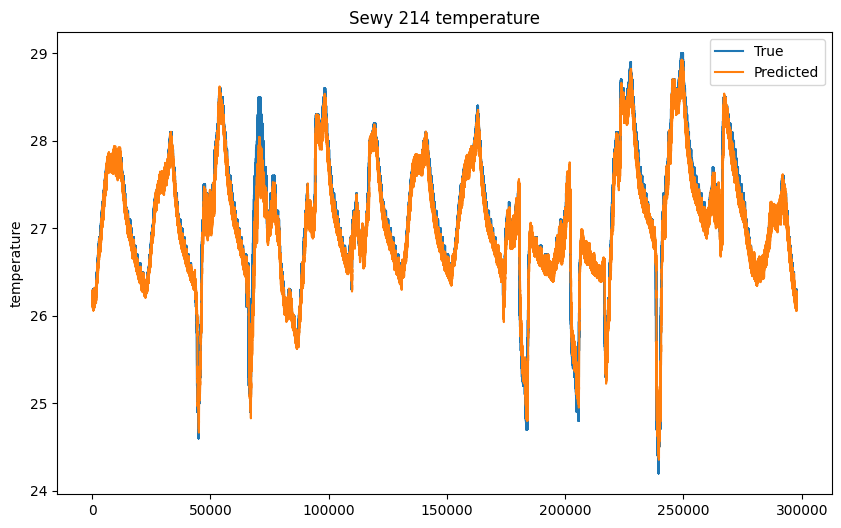

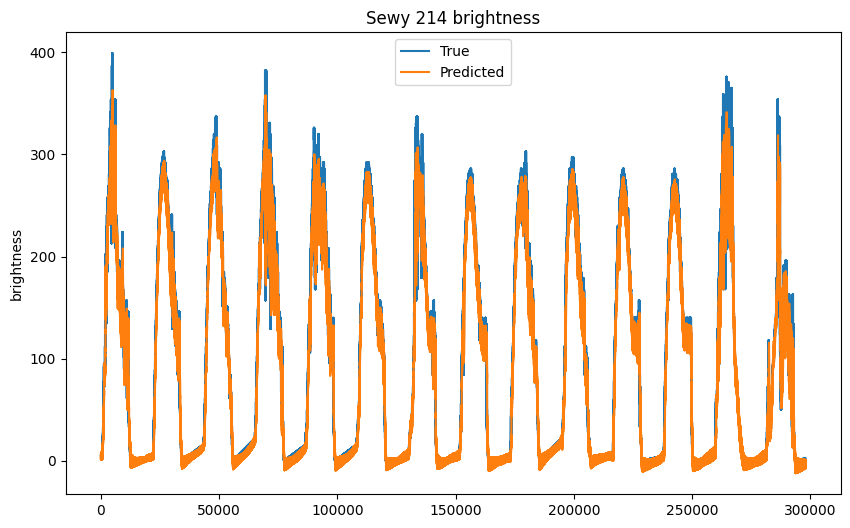

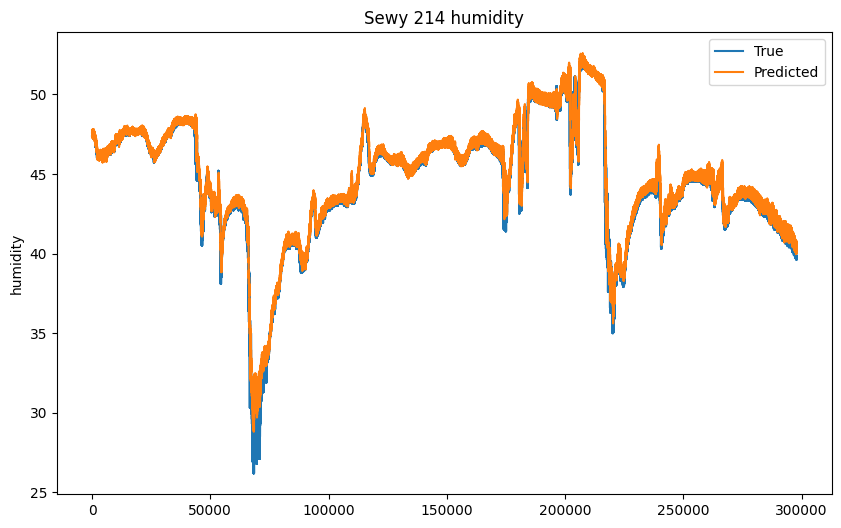

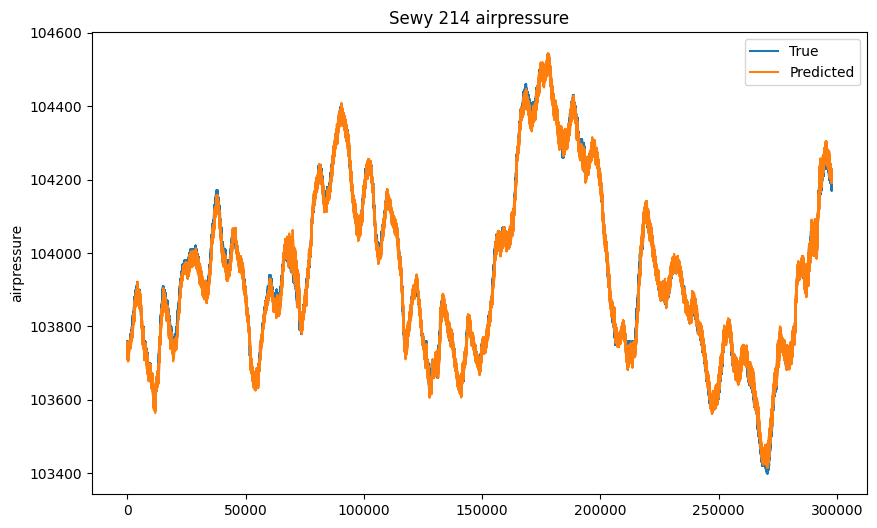

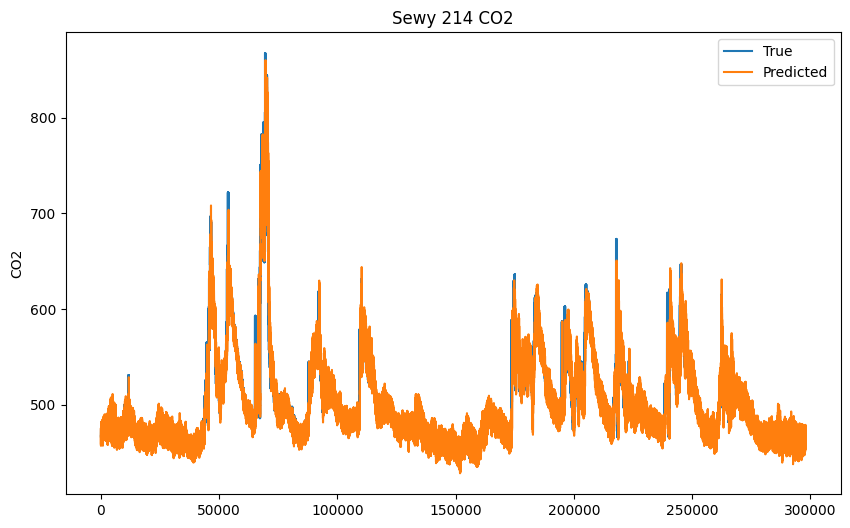

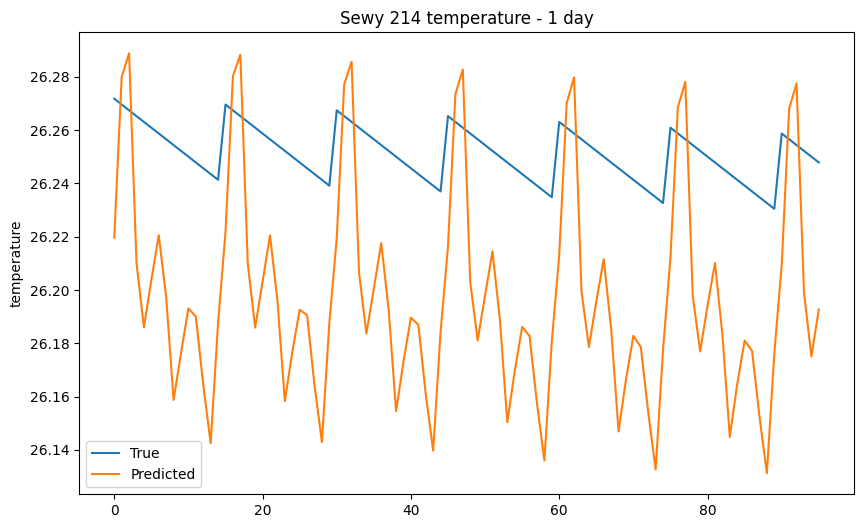

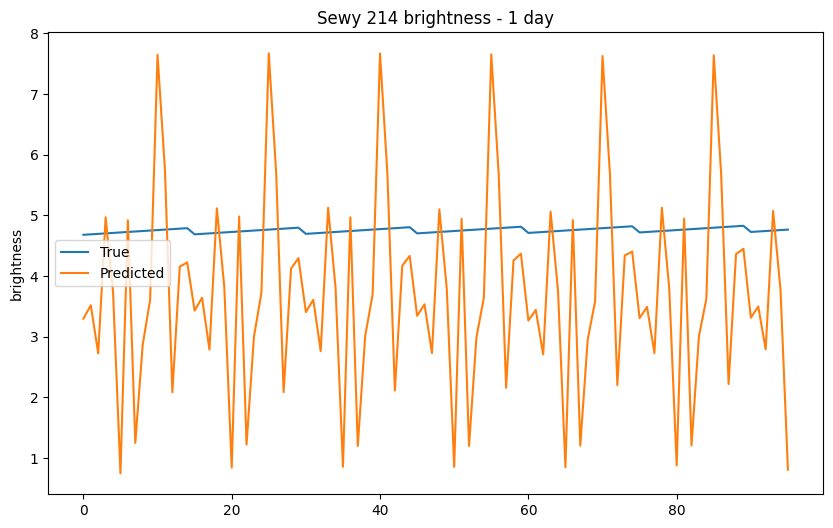

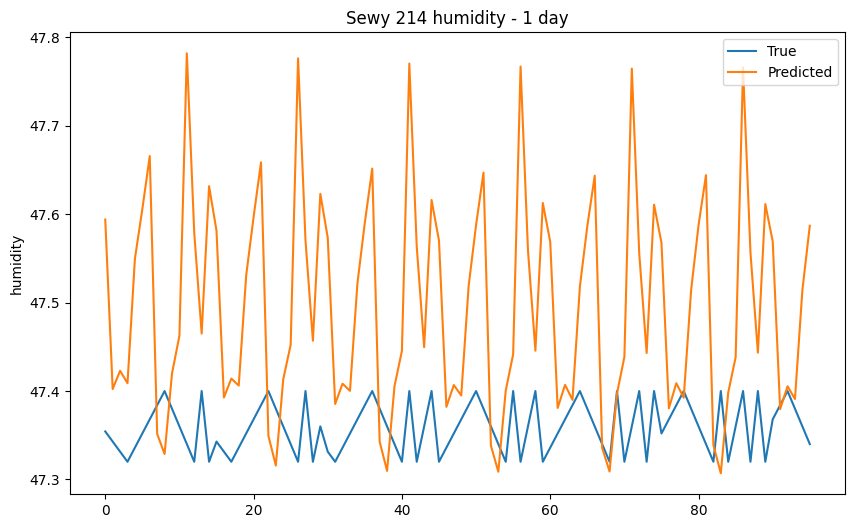

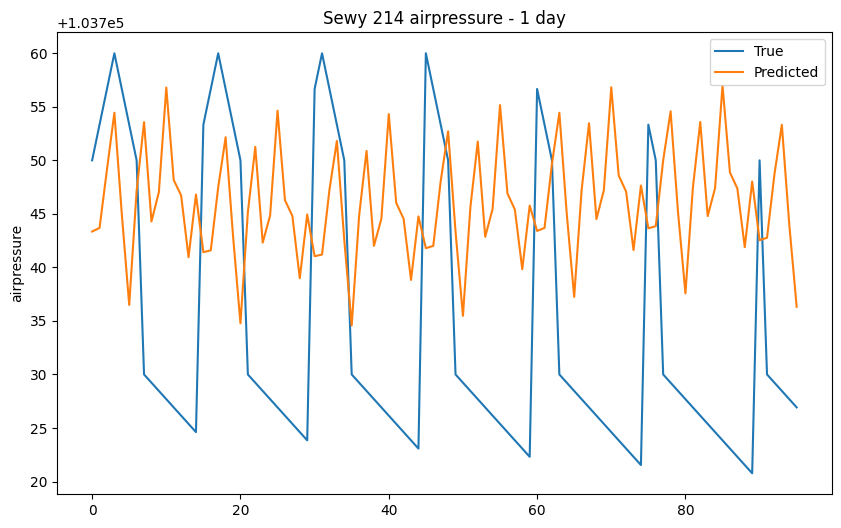

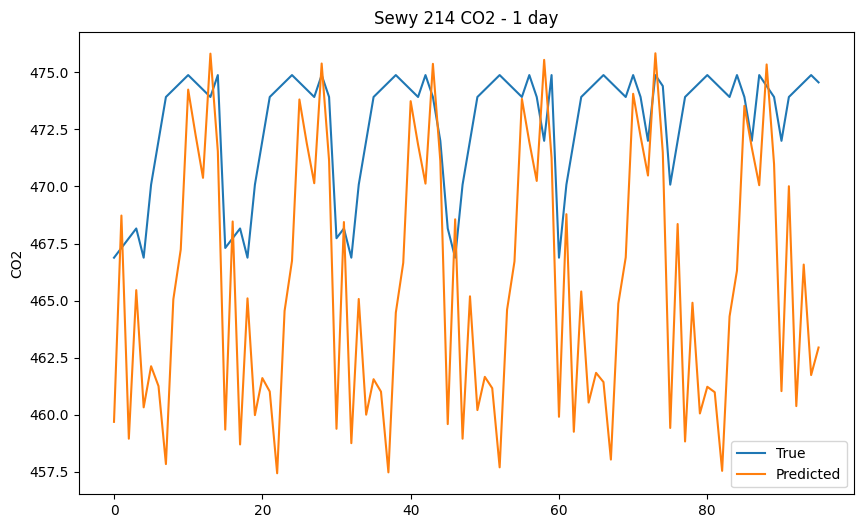

In [42]:
plot_predictions(y_test_temperature, test_predictions_temperature, 'temperature')
plot_predictions(y_test_brightness, test_predictions_brightness, 'brightness')
plot_predictions(y_test_humidity, test_predictions_humidity, 'humidity')
plot_predictions(y_test_airpressure, test_predictions_airpressure, 'airpressure')
plot_predictions(y_test_co2, test_predictions_co2, 'CO2')

plot_predictions_day(y_test_temperature, test_predictions_temperature, 'temperature')
plot_predictions_day(y_test_brightness, test_predictions_brightness, 'brightness')
plot_predictions_day(y_test_humidity, test_predictions_humidity, 'humidity')
plot_predictions_day(y_test_airpressure, test_predictions_airpressure, 'airpressure')
plot_predictions_day(y_test_co2, test_predictions_co2, 'CO2')

In [43]:
# Evaluate the predictions
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_predictions(y_test, test_predictions, name):
    print(name +' - MSE:', mean_squared_error(y_test, test_predictions))
    print(name +' - MAE:', mean_absolute_error(y_test, test_predictions))
    print(name +' - RMSE:', np.sqrt(mean_squared_error(y_test, test_predictions)))
    
evaluate_predictions(y_test_temperature, test_predictions_temperature, 'temperature')
evaluate_predictions(y_test_brightness, test_predictions_brightness, 'brightness')
evaluate_predictions(y_test_humidity, test_predictions_humidity, 'humidity')
evaluate_predictions(y_test_airpressure, test_predictions_airpressure, 'airpressure')
evaluate_predictions(y_test_co2, test_predictions_co2, 'CO2')

temperature - MSE: 0.02450282920862283
temperature - MAE: 0.11275382282778498
temperature - RMSE: 0.1565337957395234
brightness - MSE: 386.15326949905364
brightness - MAE: 11.843796344657745
brightness - RMSE: 19.650782923310043
humidity - MSE: 0.3396261859143683
humidity - MAE: 0.37980056532611683
humidity - RMSE: 0.5827745583966139
airpressure - MSE: 317.55260438790043
airpressure - MAE: 13.921162768005606
airpressure - RMSE: 17.82000573478865
CO2 - MSE: 208.00110681555964
CO2 - MAE: 9.609951709179212
CO2 - RMSE: 14.422243473730418


### Multistep / Predecir valores dentro de 60 minutos

Evaluamos para 60 minutos, 360 minutos y 720 minutos

In [44]:
horizons = [60, 360, 720]

Epoch 1/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0279 - mean_absolute_error: 0.0904 - root_mean_squared_error: 0.1489 - val_loss: 0.0011 - val_mean_absolute_error: 0.0207 - val_root_mean_squared_error: 0.0334
Epoch 2/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 9.8120e-04 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0313 - val_loss: 9.5957e-04 - val_mean_absolute_error: 0.0167 - val_root_mean_squared_error: 0.0310
Epoch 3/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 2s 918us/step - loss: 9.3865e-04 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0306 - val_loss: 0.0010 - val_mean_absolute_error: 0.0183 - val_root_mean_squared_error: 0.0321
Epoch 4/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 2s 905us/step - loss: 8.9132e-04 - mean_absolute_error: 0.0144 - root_mean_squared_error: 0.0299 - val_loss: 9.5175e-04 - val_mean_absolute_error: 0.0166 - val_root_mean_squared_error: 0.0309
Epoch 5/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 8.6048e-04 - mean_

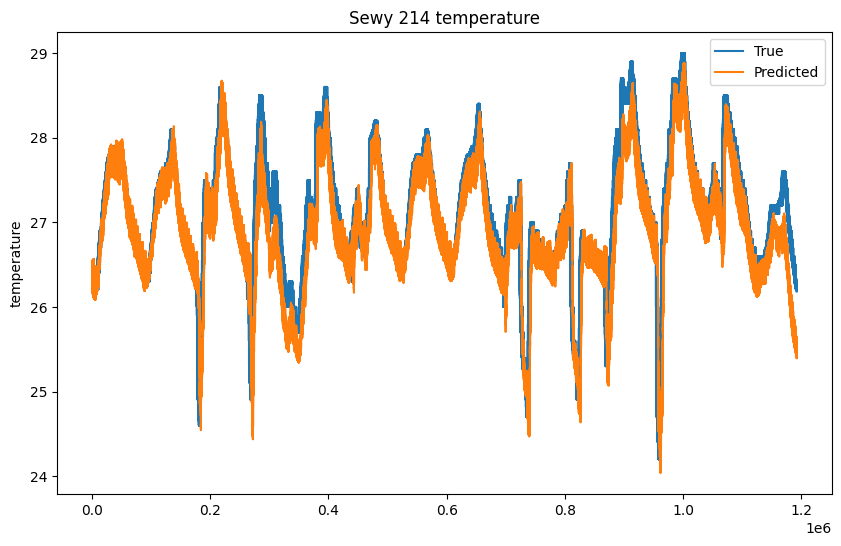

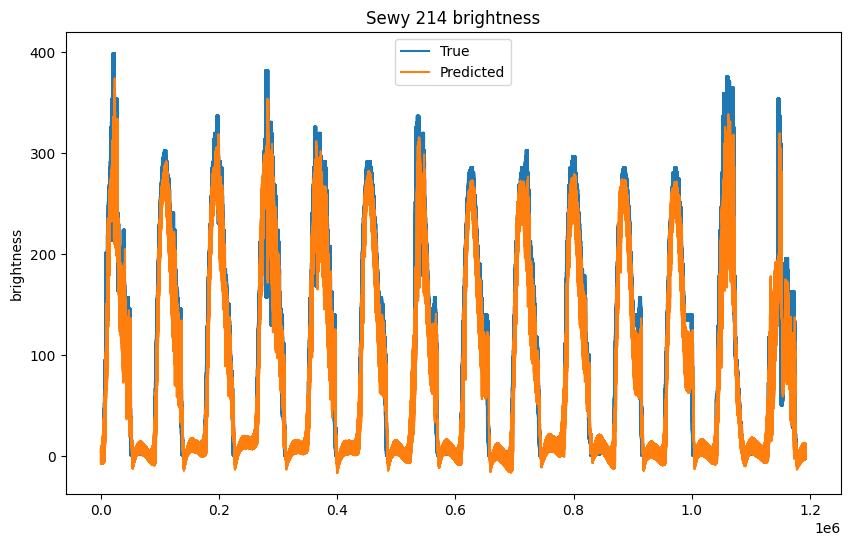

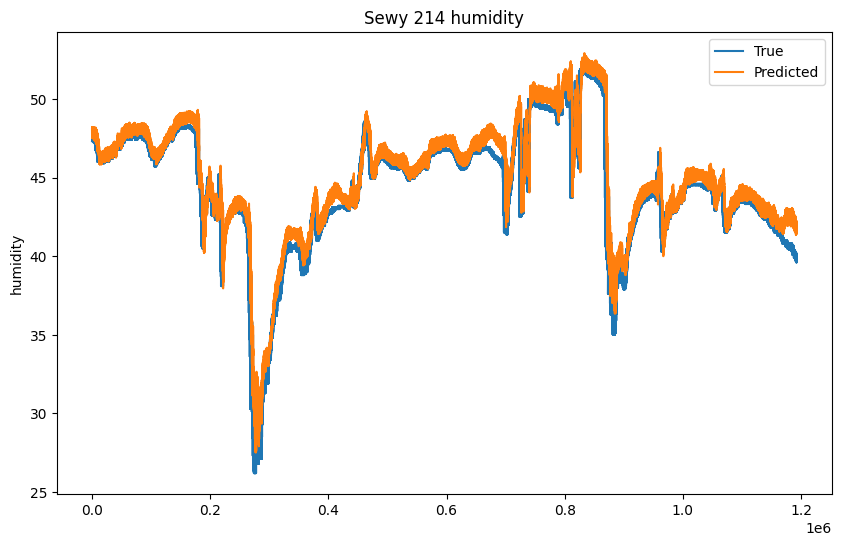

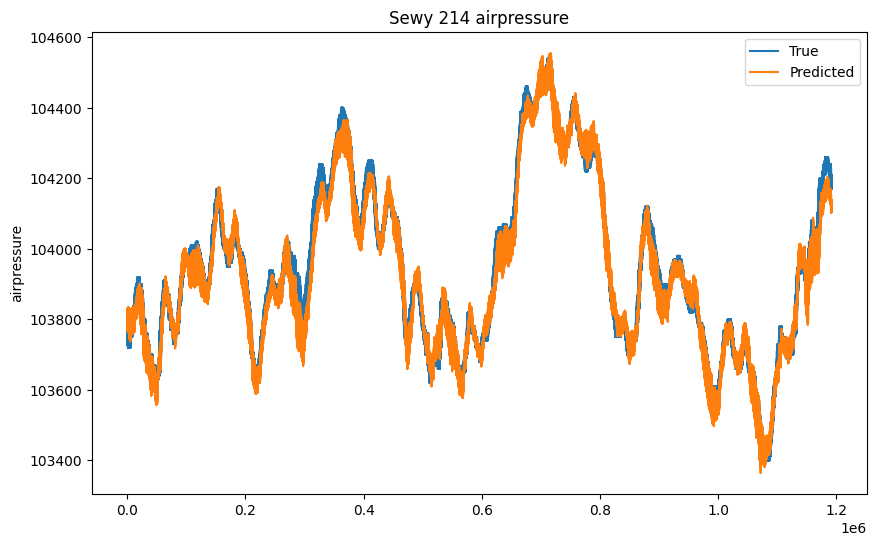

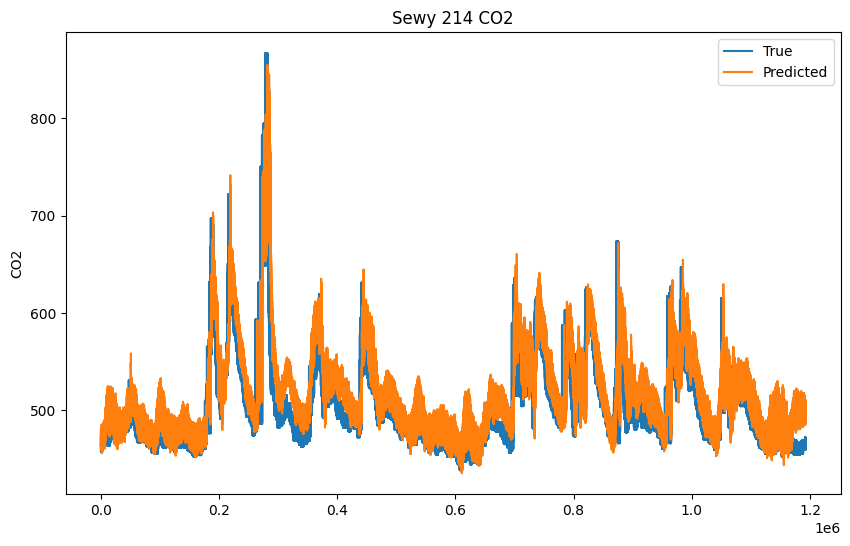

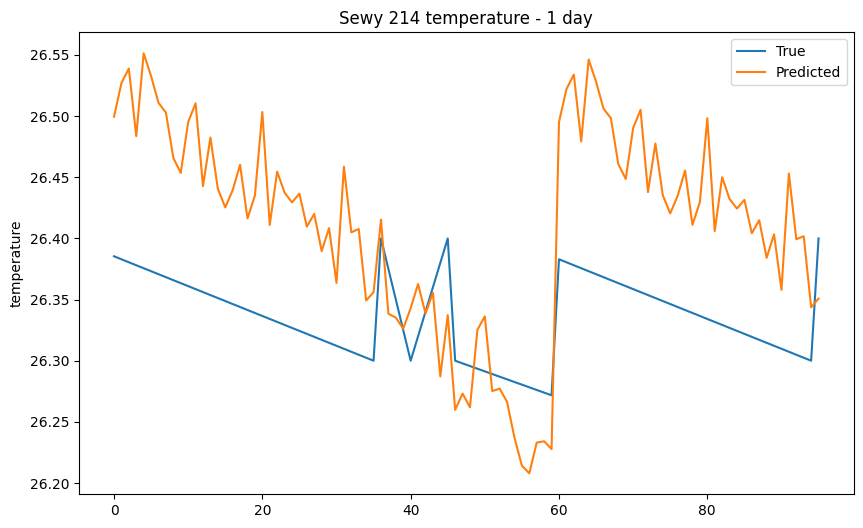

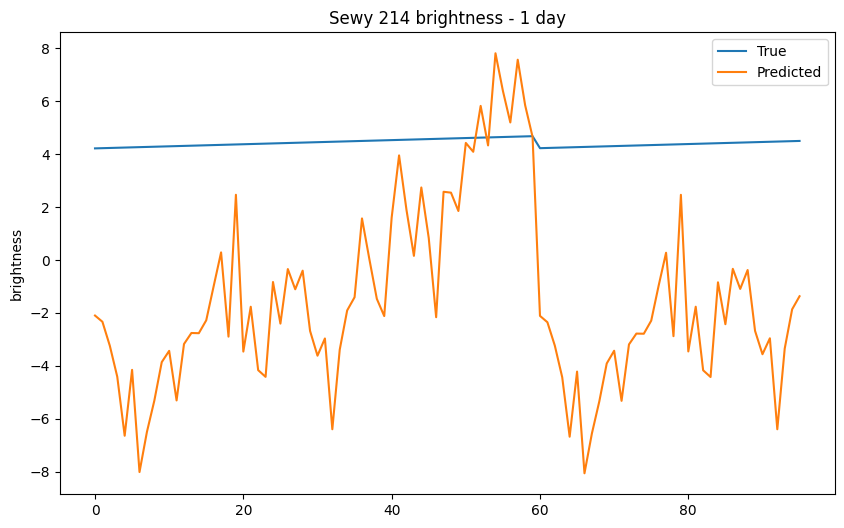

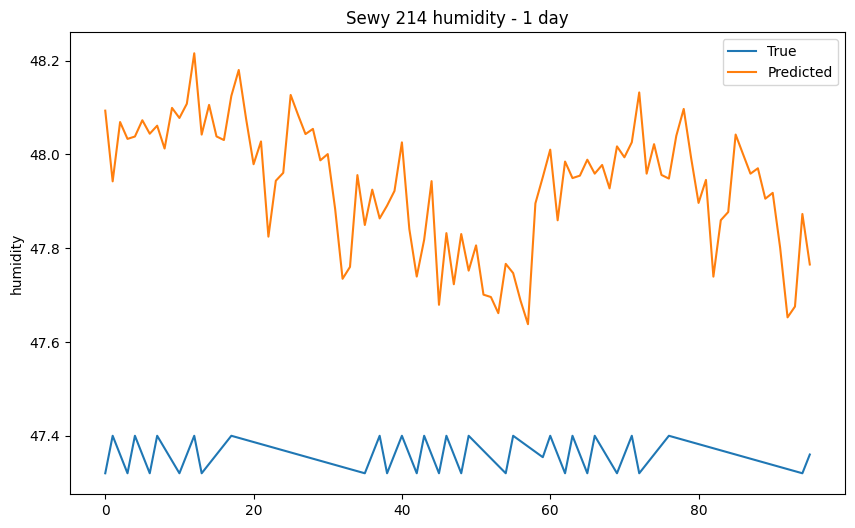

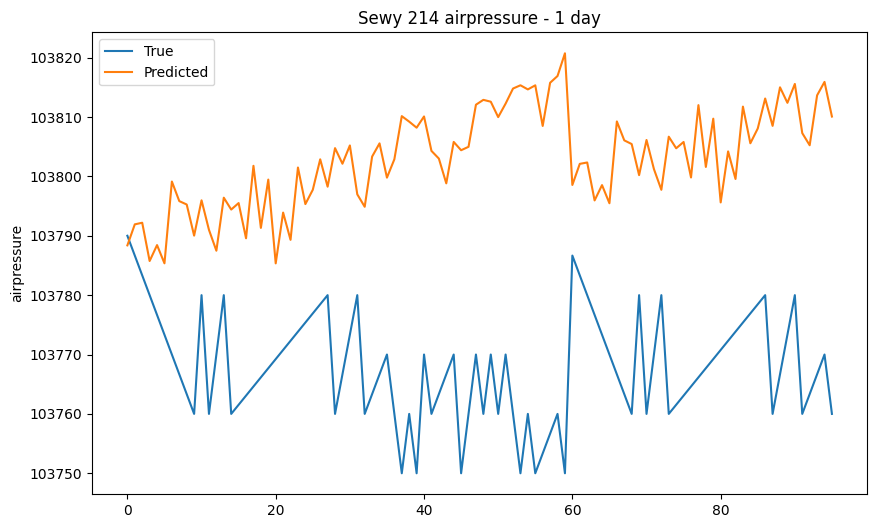

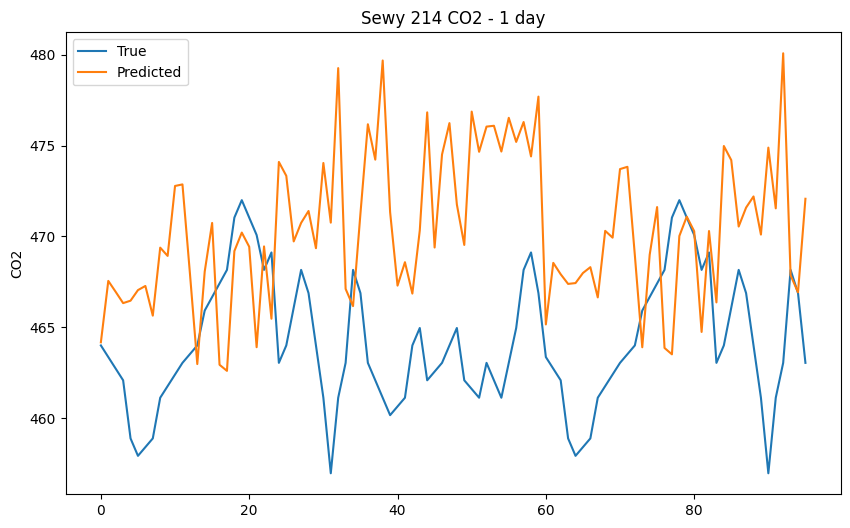

temperature - MSE: 0.11723856188224116
temperature - MAE: 0.2412403637846764
temperature - RMSE: 0.3424011709708966
brightness - MSE: 780.5305130988486
brightness - MAE: 18.19331485681077
brightness - RMSE: 27.937976181156152
humidity - MSE: 1.005506829217186
humidity - MAE: 0.70654100426095
humidity - RMSE: 1.0027496343640252
airpressure - MSE: 1481.6325539896375
airpressure - MAE: 29.55520879393126
airpressure - RMSE: 38.49198038539505
CO2 - MSE: 721.2327656358201
CO2 - MAE: 20.791209212347088
CO2 - RMSE: 26.85577713706718
Epoch 1/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0310 - mean_absolute_error: 0.1046 - root_mean_squared_error: 0.1604 - val_loss: 0.0043 - val_mean_absolute_error: 0.0487 - val_root_mean_squared_error: 0.0659
Epoch 2/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0030 - mean_absolute_error: 0.0339 - root_mean_squared_error: 0.0550 - val_loss: 0.0039 - val_mean_absolute_error: 0.0435 - val_root_mean_squared_error: 0.0623
Epoch 3/20
1986/1986 

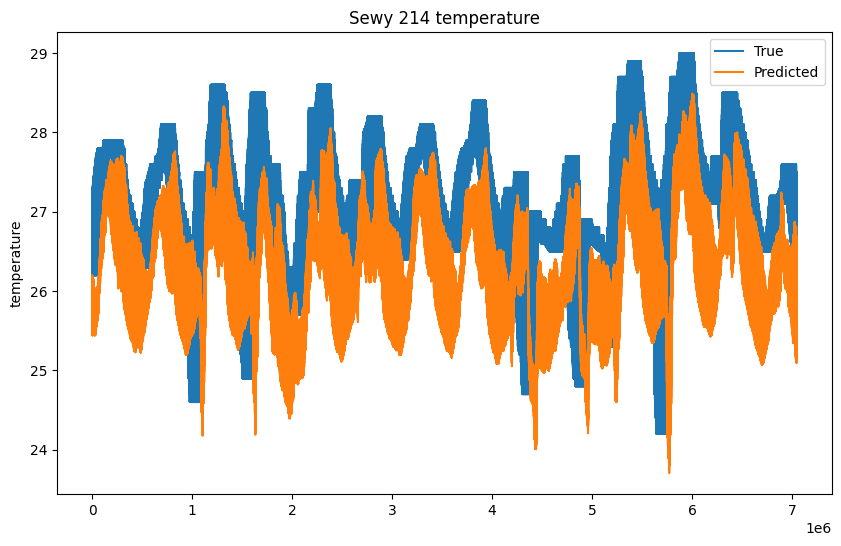

c:\Users\IvO\Desktop\testGit\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


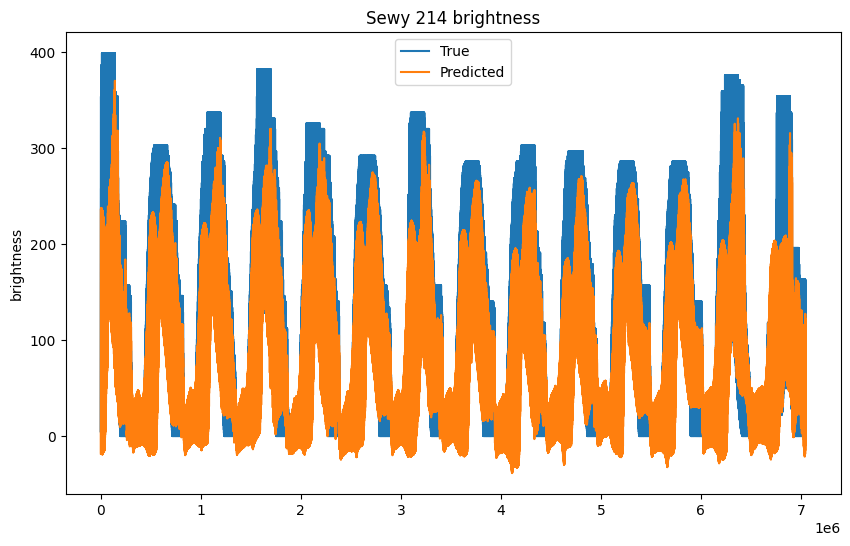

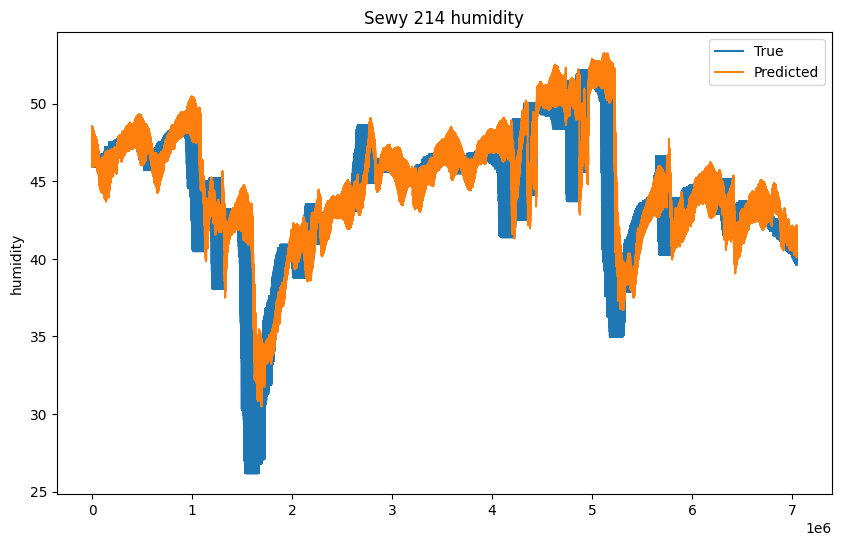

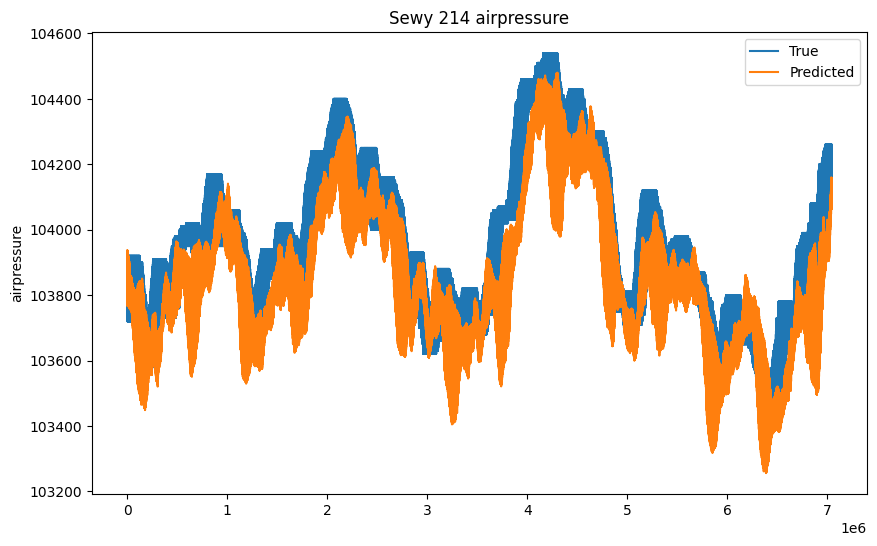

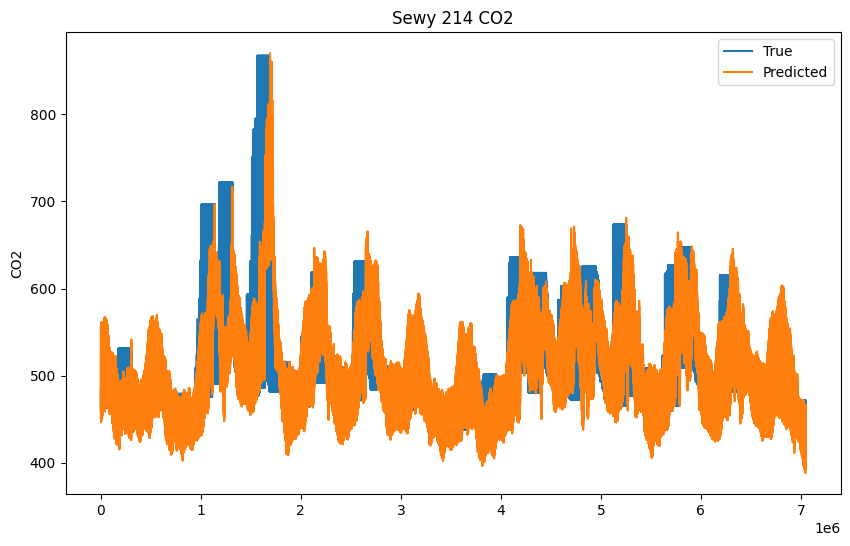

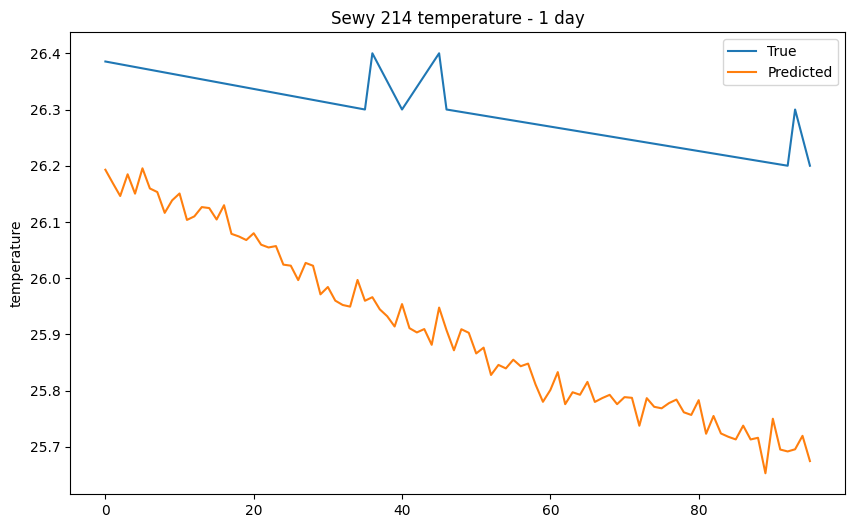

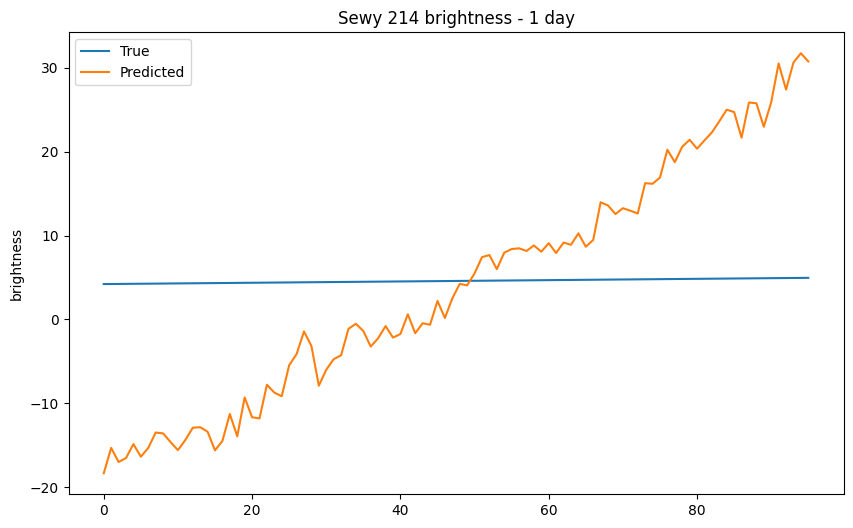

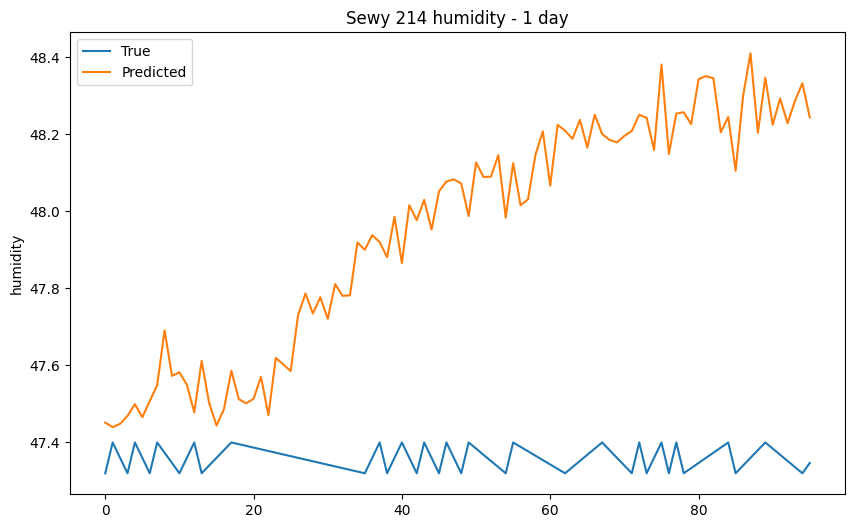

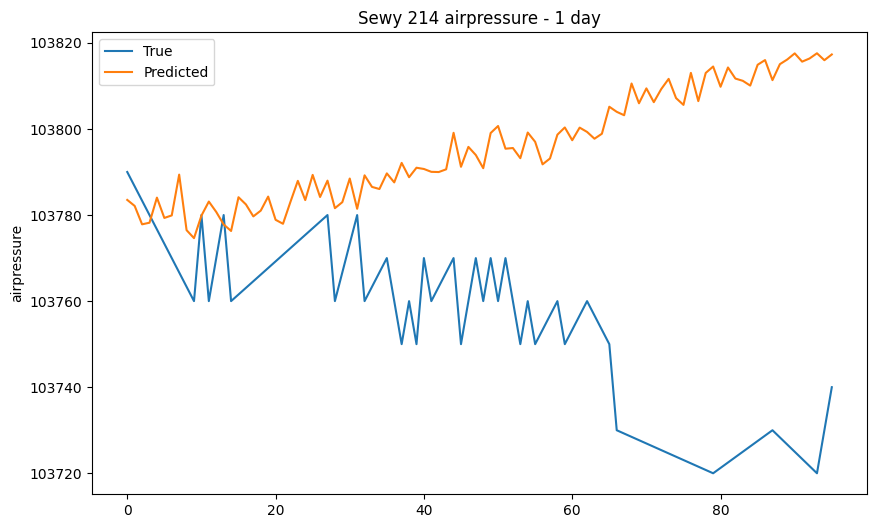

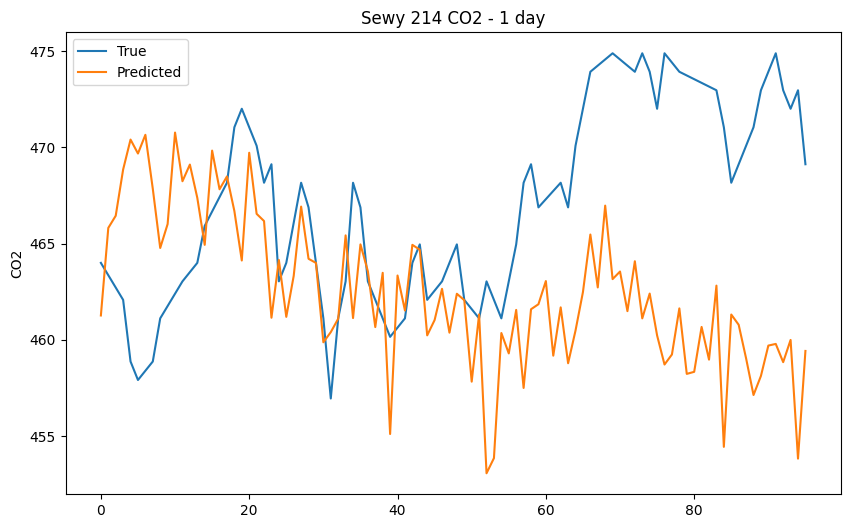

temperature - MSE: 1.1606139950986105
temperature - MAE: 0.9882184335174284
temperature - RMSE: 1.0773179637872055
brightness - MSE: 2638.8661454551043
brightness - MAE: 39.302628684744874
brightness - RMSE: 51.36989532260217
humidity - MSE: 5.086490779580585
humidity - MAE: 1.3301224577825201
humidity - RMSE: 2.2553249831411404
airpressure - MSE: 17482.180027229406
airpressure - MAE: 106.39870828191485
airpressure - RMSE: 132.22019523215585
CO2 - MSE: 2035.6061508844575
CO2 - MAE: 32.14912556033355
CO2 - RMSE: 45.11769221585317
Epoch 1/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0315 - mean_absolute_error: 0.1084 - root_mean_squared_error: 0.1629 - val_loss: 0.0046 - val_mean_absolute_error: 0.0487 - val_root_mean_squared_error: 0.0676
Epoch 2/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0045 - mean_absolute_error: 0.0431 - root_mean_squared_error: 0.0668 - val_loss: 0.0044 - val_mean_absolute_error: 0.0466 - val_root_mean_squared_error: 0.0663
Epoch 3/20
1986/1

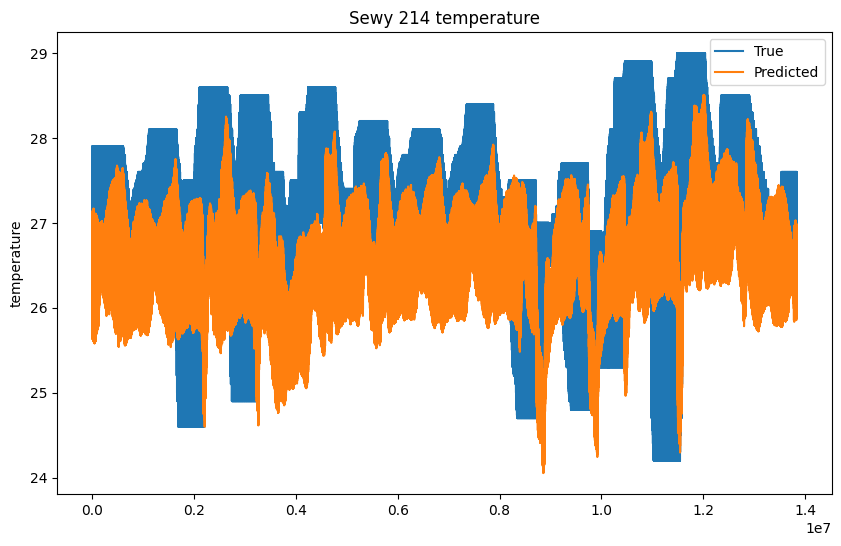

c:\Users\IvO\Desktop\testGit\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


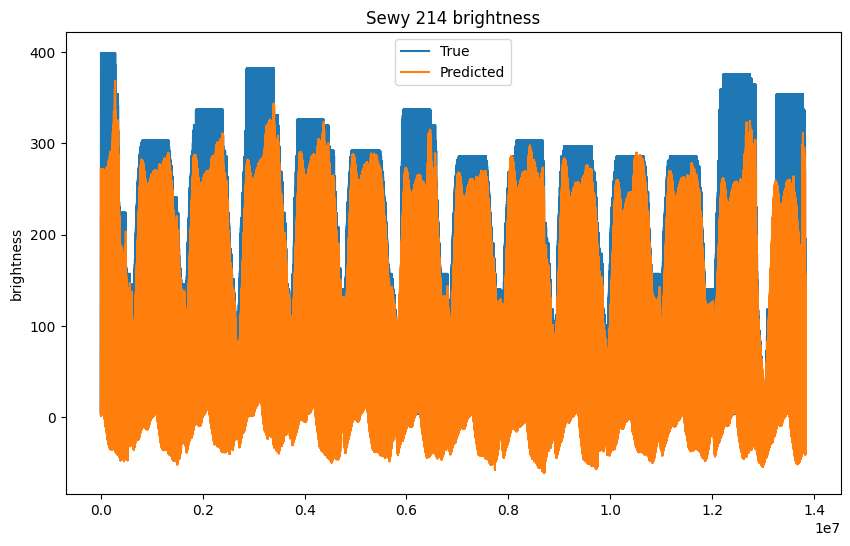

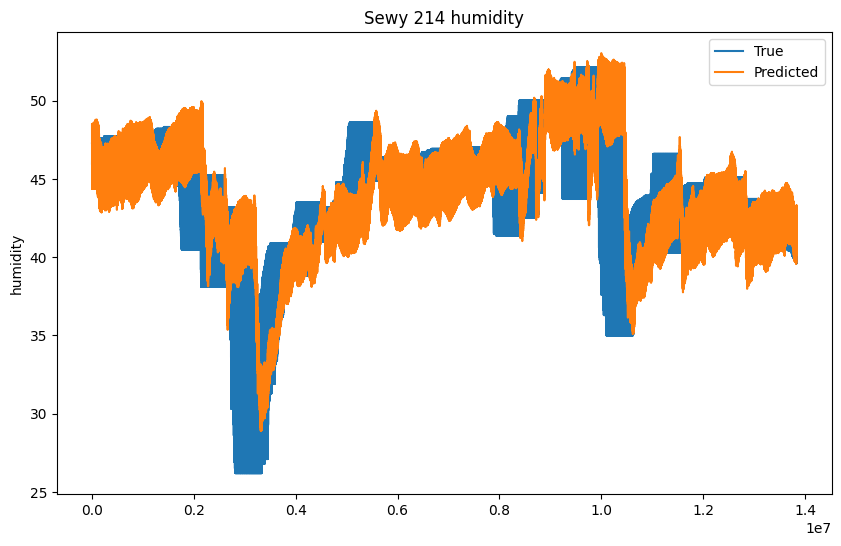

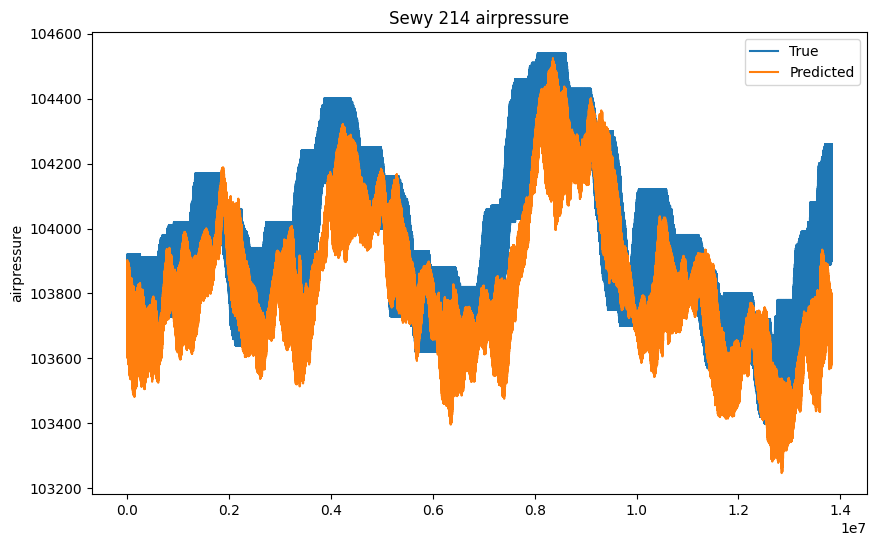

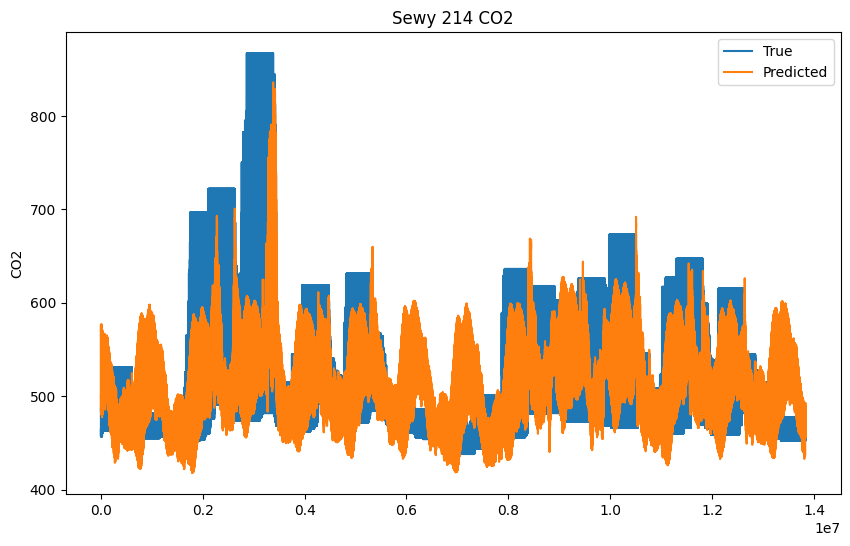

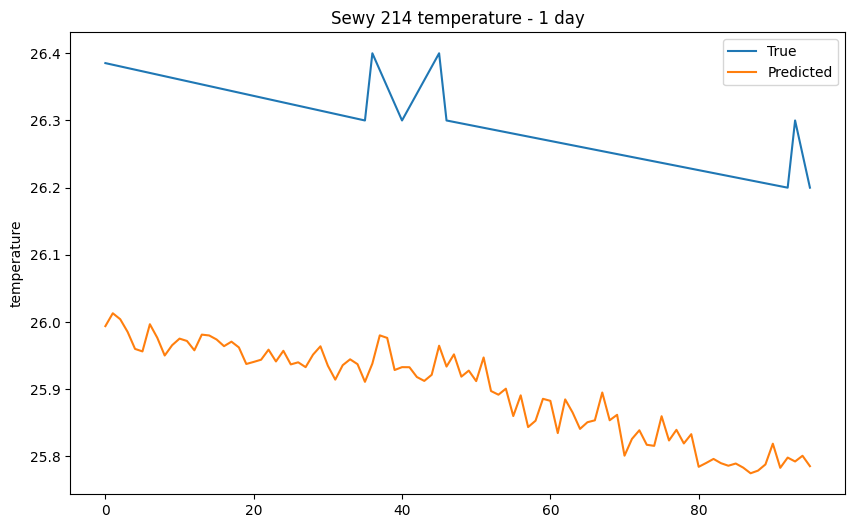

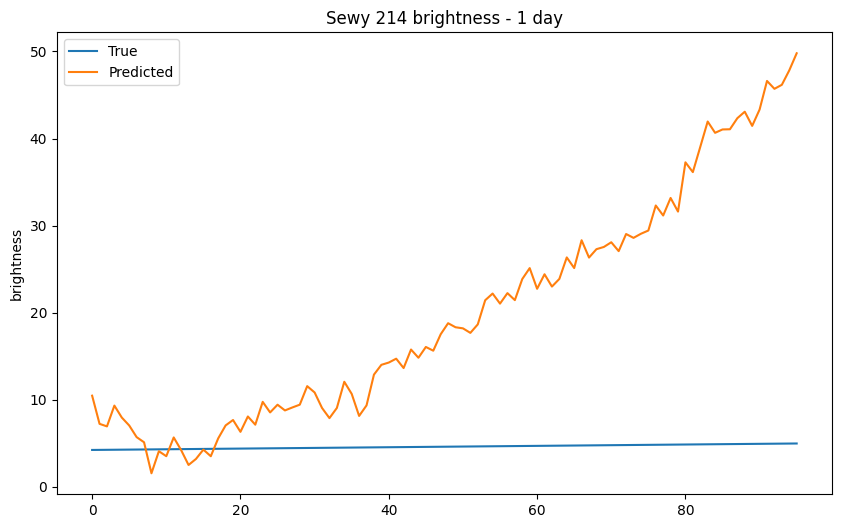

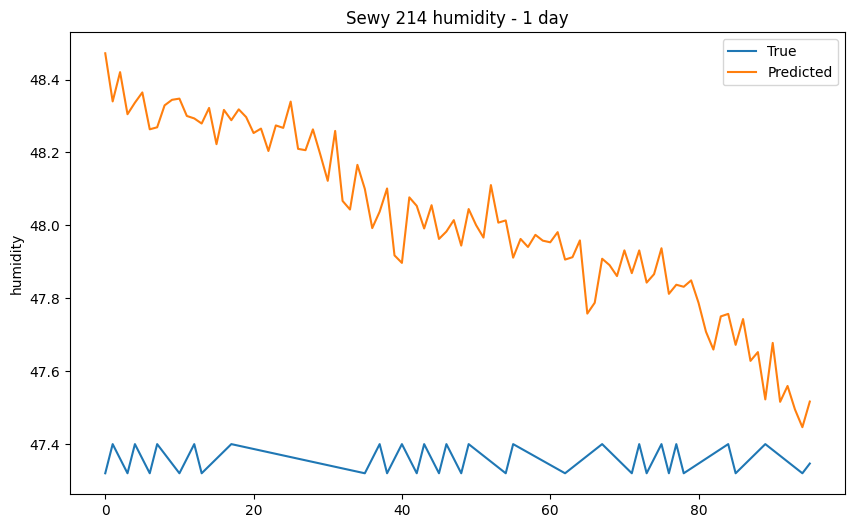

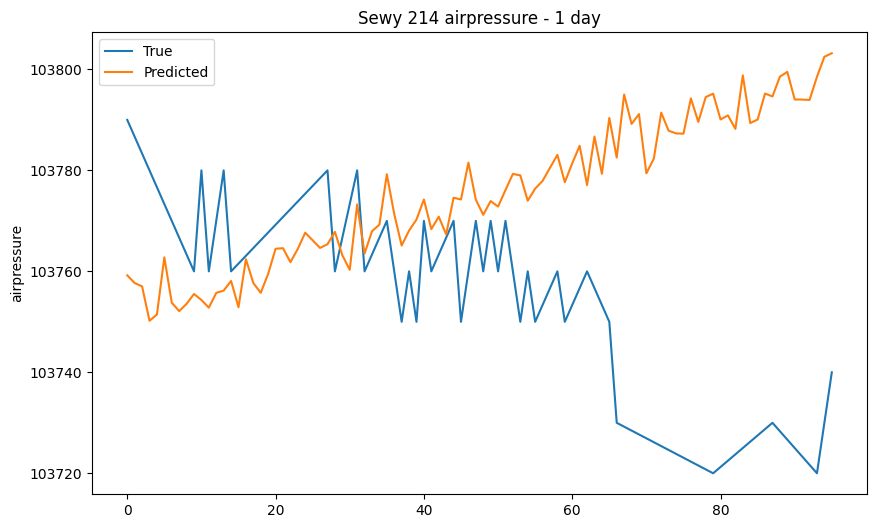

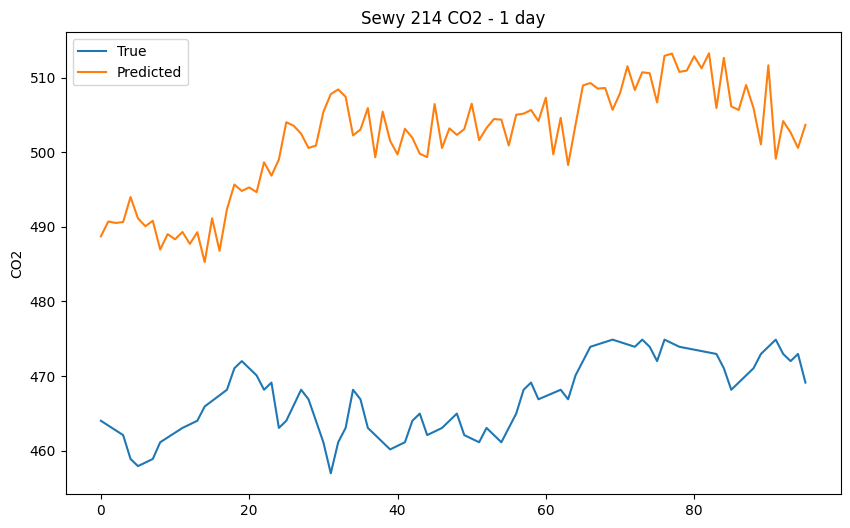

temperature - MSE: 0.7870319465850654
temperature - MAE: 0.7575616705427684
temperature - RMSE: 0.8871482100444466
brightness - MSE: 2354.740416275734
brightness - MAE: 36.13346010613179
brightness - RMSE: 48.52566760257641
humidity - MSE: 8.071121437078116
humidity - MAE: 1.956670282386317
humidity - RMSE: 2.840971917685586
airpressure - MSE: 30160.90339804635
airpressure - MAE: 134.71867949146926
airpressure - RMSE: 173.6689477081218
CO2 - MSE: 1898.1775417958884
CO2 - MAE: 30.66699594363854
CO2 - RMSE: 43.56807939071779


In [45]:
for horizon in horizons:
    X, y = split_sequence(completed_df, 1, horizon)
    X_train, X_test = X[:lsmt_separation_rows], X[lsmt_separation_rows:]
    y_train, y_test = y[:lsmt_separation_rows], y[lsmt_separation_rows:]

    HandMadeLSTM = Sequential()
    HandMadeLSTM.add(InputLayer((1, len(completed_df.columns))))
    HandMadeLSTM.add(LSTM(64, activation='relu'))
    HandMadeLSTM.add(Dense(horizon*(len(completed_df.columns)-4)))

    modelPath = f'../LSMTTensorflow/bestModel_sewy_214_{horizon}.keras'
    checkpoints = ModelCheckpoint(modelPath, save_best_only=True)
    HandMadeLSTM.compile(optimizer=Adam(learning_rate=0.001), loss=mse_tf(), metrics=[mae_tf(), RootMeanSquaredError()])

    HandMadeLSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[checkpoints])

    HandMadeLSTM = load_model(modelPath)

    test_predictions_temperature, test_predictions_brightness, test_predictions_humidity, test_predictions_airpressure, test_predictions_co2, y_test_temperature, y_test_brightness, y_test_humidity, y_test_airpressure, y_test_co2 = inverse_transform_dataset(HandMadeLSTM.predict(X_test), y_test)
    
    plot_predictions(y_test_temperature, test_predictions_temperature, 'temperature')
    plot_predictions(y_test_brightness, test_predictions_brightness, 'brightness')
    plot_predictions(y_test_humidity, test_predictions_humidity, 'humidity')
    plot_predictions(y_test_airpressure, test_predictions_airpressure, 'airpressure')
    plot_predictions(y_test_co2, test_predictions_co2, 'CO2')

    plot_predictions_day(y_test_temperature, test_predictions_temperature, 'temperature')
    plot_predictions_day(y_test_brightness, test_predictions_brightness, 'brightness')
    plot_predictions_day(y_test_humidity, test_predictions_humidity, 'humidity')
    plot_predictions_day(y_test_airpressure, test_predictions_airpressure, 'airpressure')
    plot_predictions_day(y_test_co2, test_predictions_co2, 'CO2')
    
    evaluate_predictions(y_test_temperature, test_predictions_temperature, 'temperature')
    evaluate_predictions(y_test_brightness, test_predictions_brightness, 'brightness')
    evaluate_predictions(y_test_humidity, test_predictions_humidity, 'humidity')
    evaluate_predictions(y_test_airpressure, test_predictions_airpressure, 'airpressure')
    evaluate_predictions(y_test_co2, test_predictions_co2, 'CO2')
    
    

In [46]:
# Guardamos los datos necesarios para transformar los datos de normalización a los datos originales
dump(scaler_temperature, open('scalers/sewy/scaler_temperature_sewy_214.pkl', 'wb'))
dump(scaler_brightness, open('scalers/sewy/scaler_brightness_sewy_214.pkl', 'wb'))
dump(scaler_humidity, open('scalers/sewy/scaler_humidity_sewy_214.pkl', 'wb'))
dump(scaler_airpressure, open('scalers/sewy/scaler_airpressure_sewy_214.pkl', 'wb'))
dump(scaler_co2, open('scalers/sewy/scaler_co2_sewy_214.pkl', 'wb'))


In [47]:
scaler_temperature.data_max_, scaler_brightness.data_max_, scaler_humidity.data_max_, scaler_airpressure.data_max_, scaler_co2.data_max_, scaler_temperature.data_min_, scaler_brightness.data_min_, scaler_humidity.data_min_, scaler_airpressure.data_min_, scaler_co2.data_min_

(array([26.6]),
 array([386.88]),
 array([64.12]),
 array([104830.]),
 array([1690.88]),
 array([17.9]),
 array([0.]),
 array([31.6]),
 array([102930.]),
 array([392.96]))